In [1]:
## Optional, widen the notebook out to full width

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso

## Load the data

In [2]:
return_df = pd.read_excel('data.xlsx', sheet_name='returns data')
return_df = return_df.set_index(['perf_date'])
return_df.index = pd.to_datetime(return_df.index)

## Remove outliers
Upon initial inspection of the data, I noticed that there were spikes present in some factors, so the first step is to repalce them with with NaNs.

In [3]:
from typing import Union

def robust_z_score(
    factor_series: pd.Series, # a columns of the factor dataframe 
    n: int, # the number of data points to remove at either end of the sorted-by-value series 
) -> pd.Series:
    """
    This function computes z-scores of each elements of a pandas series after removing the largest and 
    smallest n elements, whose inclusion would distort the values of z-scores for the rest of the timeseries.
    """
    filtered_factors_df = factor_series.sort_values().iloc[n: -n]
    filtered_mean = filtered_factors_df.mean()
    filtered_std = filtered_factors_df.std()
    z_score = (factor_series - filtered_mean) / filtered_std
    return z_score


def detect_and_remove_outliers(
    df: pd.DataFrame, # i.e., the factor dataframe
    n: int, # the number of data points to remove at either end of the sorted-by-value series for each column, used in robust_z_score
    z_threshold: Union[float, int], # the absolute value of a z_score threshold above which an element would be considered to be an outlier
    verbose=True, # whether to print out outlier(s) detected
) -> pd.DataFrame:
    """
    This functions detects the outliers in a dataframe on a column-by-column basis, and replaces
    all outliers detected with nan then outputs the cleaned dataframe
    """
    for col in df:
        z_score = robust_z_score(df[col], n=n)
        bools = z_score.abs() > z_threshold
        if bools.any():
            if verbose:
                print(f'Outlier(s) detected for {col}:')
                print(df.loc[z_score[bools].index, col])
                print('\n')
            df.loc[z_score[bools].index, col] = np.nan
    return df

In [4]:
cleaned_return_df = detect_and_remove_outliers(
    df=return_df,
    n=3,
    z_threshold=10,
)

Outlier(s) detected for Factor - Value vs Growth:
perf_date
2020-12-31   -12739.631010
2021-01-31    10069.791609
2021-02-28    31963.201493
Name: Factor - Value vs Growth, dtype: float64


Outlier(s) detected for Factor - Interest Rates:
perf_date
2008-01-31    23213.711045
2008-02-29     5867.505916
2008-03-31     3149.873353
Name: Factor - Interest Rates, dtype: float64




## Missing value imputation

Given that some factors provided are correlated with each other (which can be observed by looking at their time history and the heatmap for pairwise correlation as shown later in this notebook), it is possible to infer missing values with the elements of other factors corresponding to the same timestamp. This is a better alternative to just filling NaNs with 0's and just dropping all rows with NaNs elements altogether, given the relatively small size of the dataset provided.

In [5]:
## Data points prior to 2008 from 'Factor - Crowding' are all zeros, this could be becasue 
## the data was not being colelcted back then. So one should treat them as missing values by
## setting them to NaN. 

cleaned_return_df.loc[:'2008-01-01', 'Factor - Crowding'] = np.nan

In [6]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [7]:
def impute_missing_return_values(
    cleaned_return_df: pd.DataFrame, # i.e., the return dataframe with outliers and missing values marked out as NaNs
    max_iter=50, # the number of rounds of interation to perform to infer the missing values
) -> pd.DataFrame:
    """
    This function imputes missing values in the cleaned return dataframe with multivariate Bayesian Ridge regression
    using scikit-learn object IterativeImputer, which models each factor with missing values as a function of other factors 
    and uses that estimate for imputation.
    """
    ## First split the cleaned dataframe into the one with rows with missing values, 
    ## and the other where each element has a valid entry.
    nan_return_df = cleaned_return_df.loc[
        cleaned_return_df.index[cleaned_return_df.isna().any(axis=1)],
        :
    ]
    valid_return_df = cleaned_return_df.loc[
        cleaned_return_df.index[~cleaned_return_df.isna().any(axis=1)],
        :
    ]
    
    ## Initialise the train the iterative imputer with the dataframe without any missing values
    imp = IterativeImputer(max_iter=max_iter, random_state=0)
    imp.fit(valid_return_df)
    
    ## Infer the missing values with the imputer trained
    impuatation_df = pd.DataFrame(
        np.round(imp.transform(nan_return_df), 4),
        index=nan_return_df.index,
        columns=nan_return_df.columns
    )
    
    ## Fill the NaNs with imputed values
    cleaned_return_df = cleaned_return_df.fillna(impuatation_df)
    
    return cleaned_return_df

In [8]:
cleaned_return_df = impute_missing_return_values(
    cleaned_return_df=cleaned_return_df,
    max_iter=50,
)

## Exploratory data analysis

With outliers removed and missing values imputed, the next step is exploratory data analysis to see if there is any data pre-processing is required before fitting the model and if there are any features exhibited by the data that can be used to aid with the model construction.

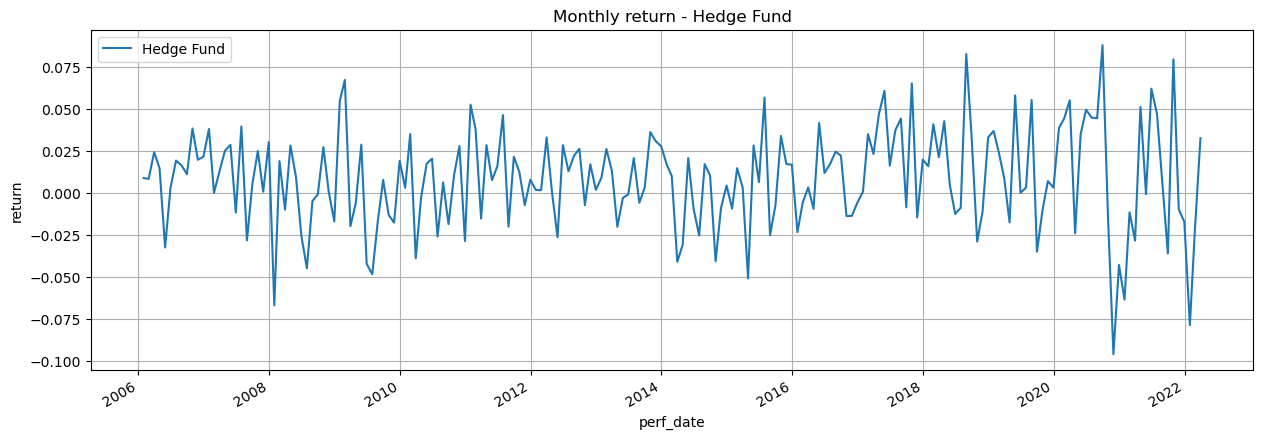

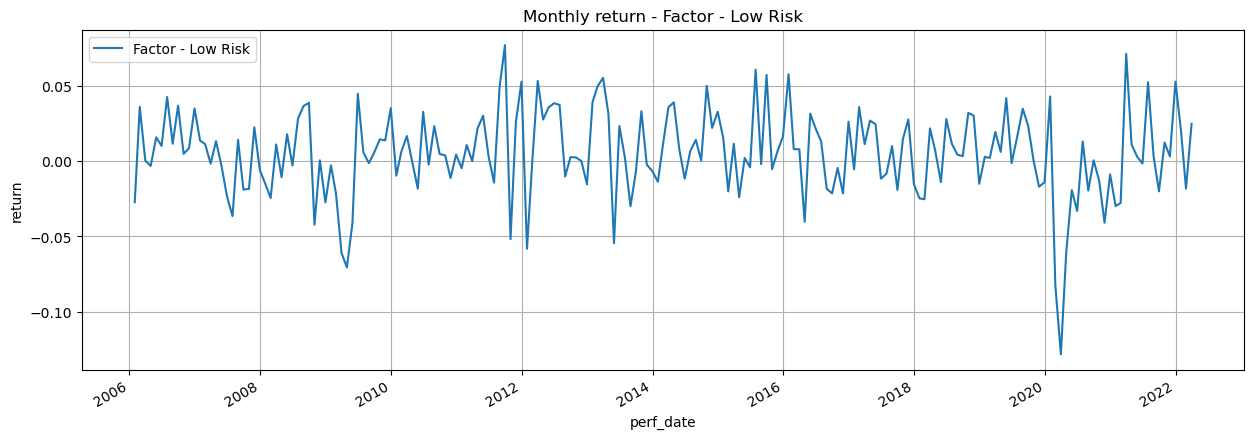

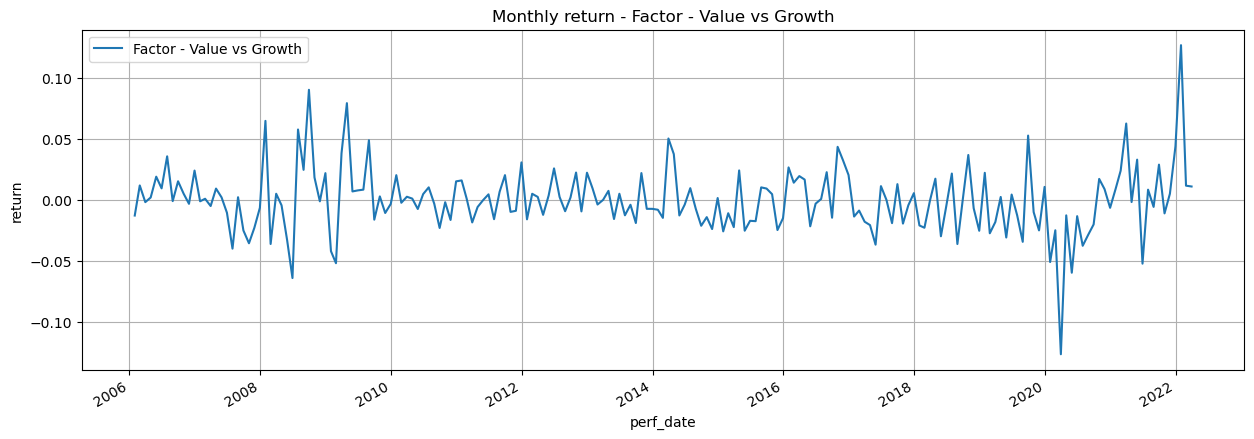

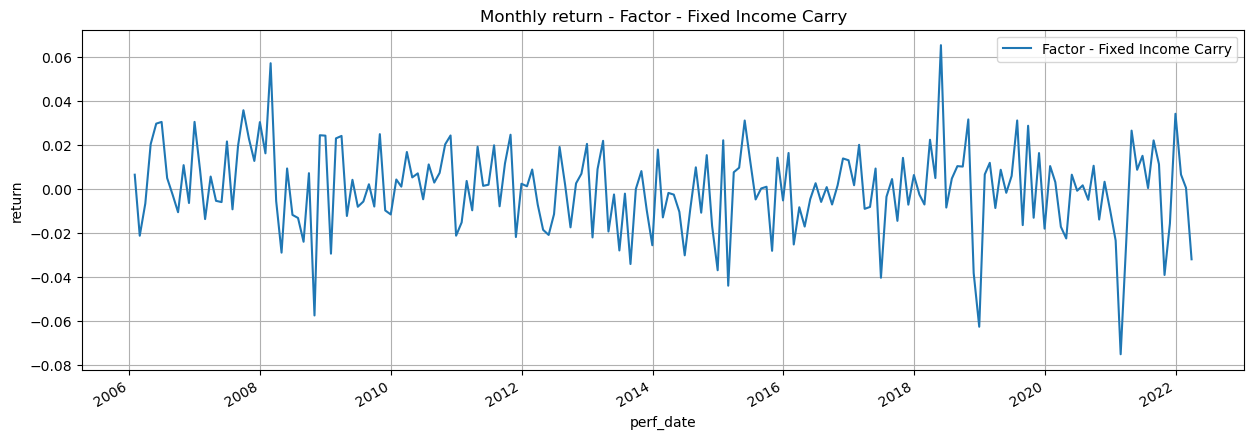

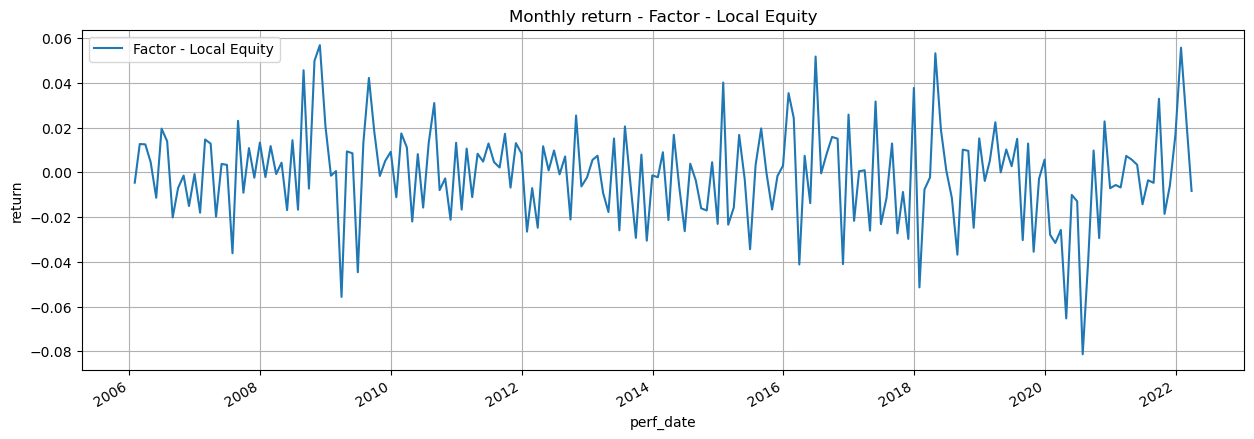

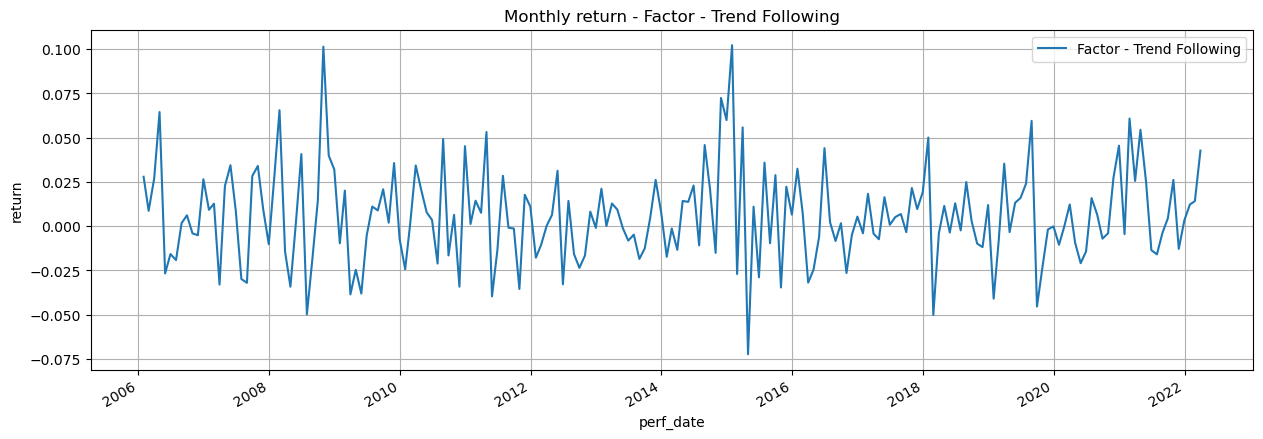

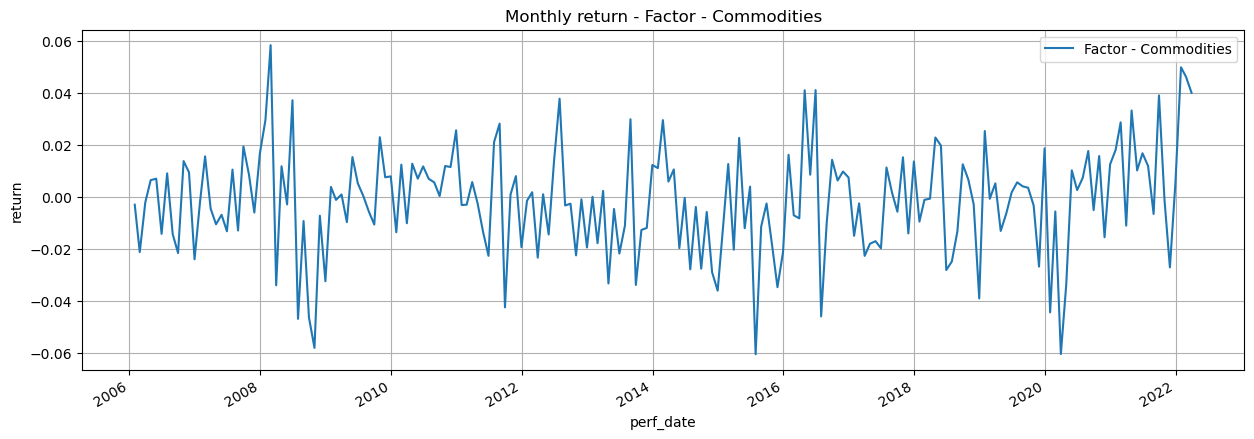

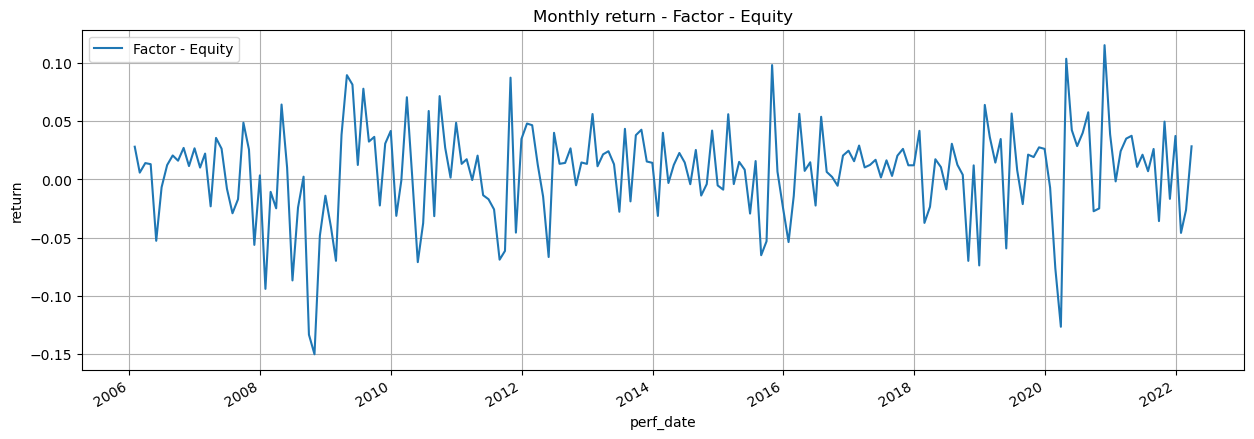

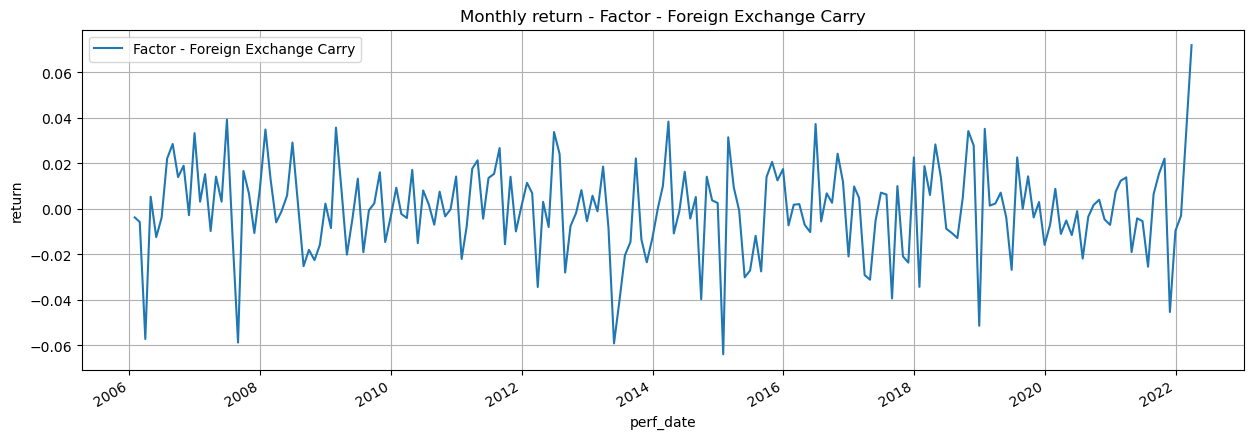

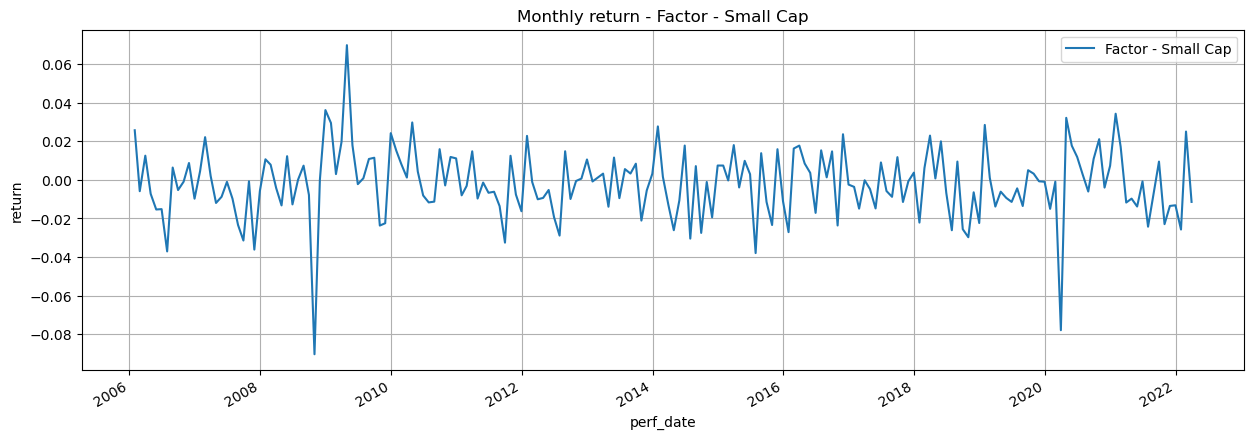

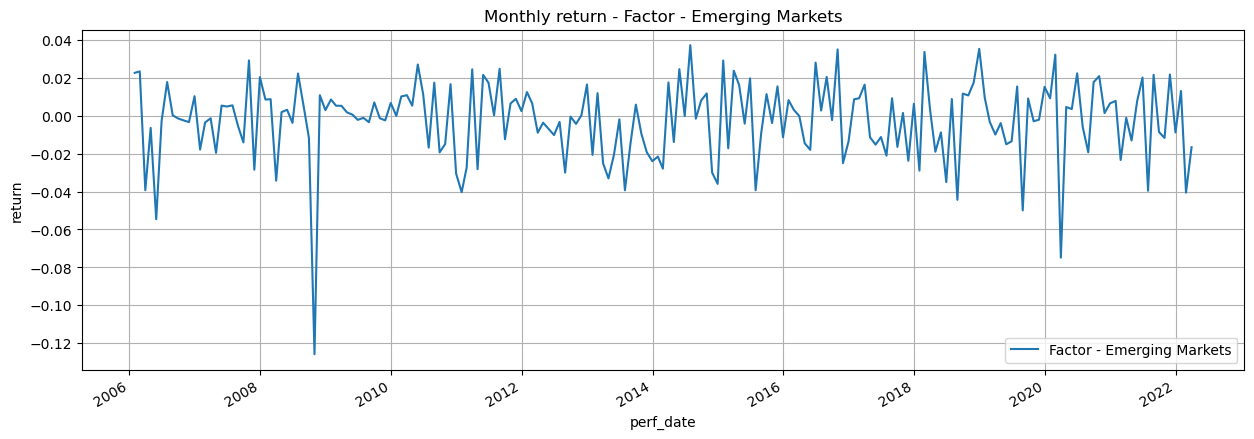

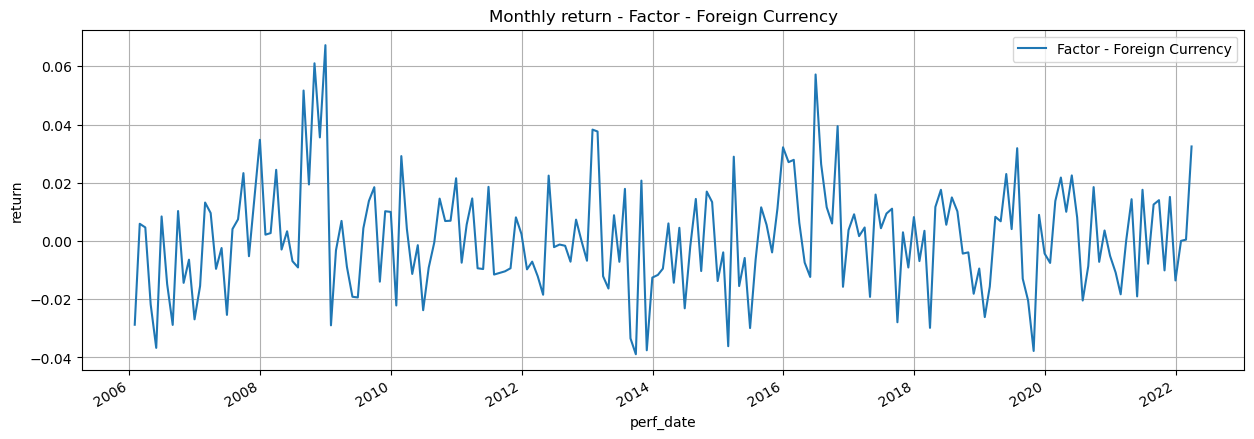

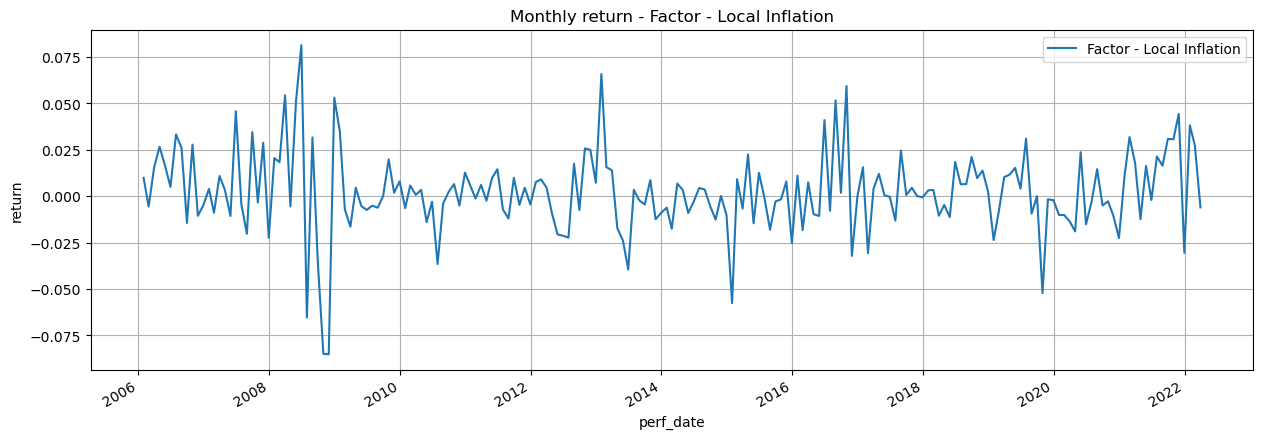

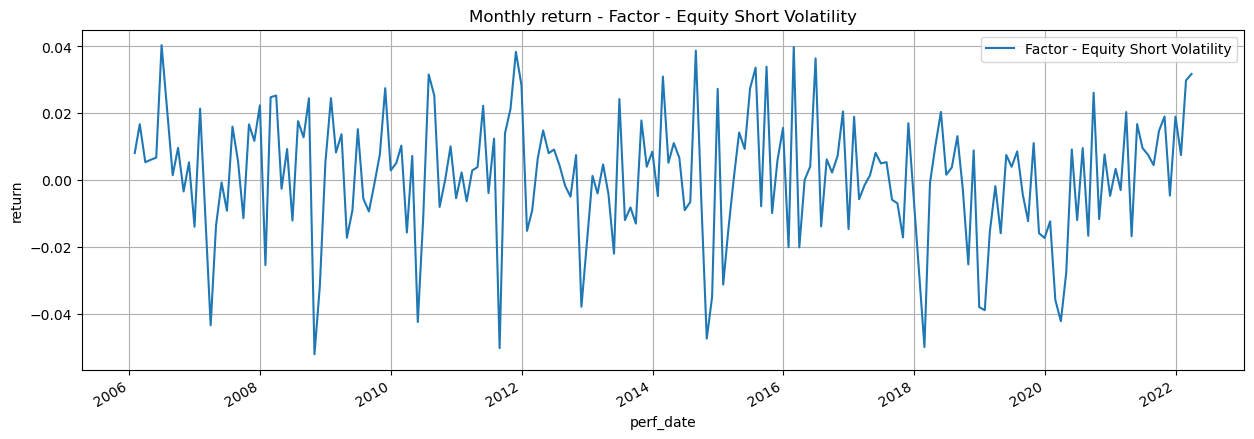

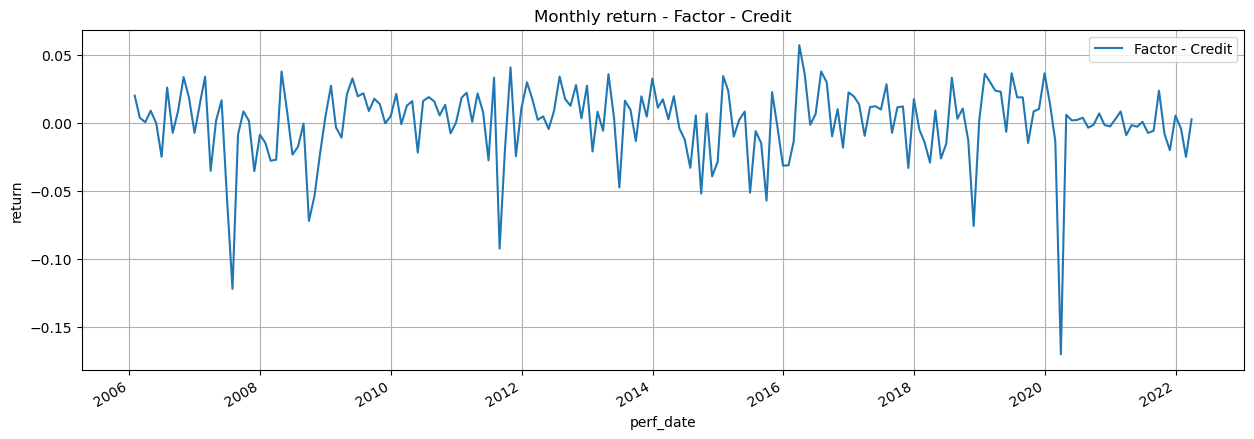

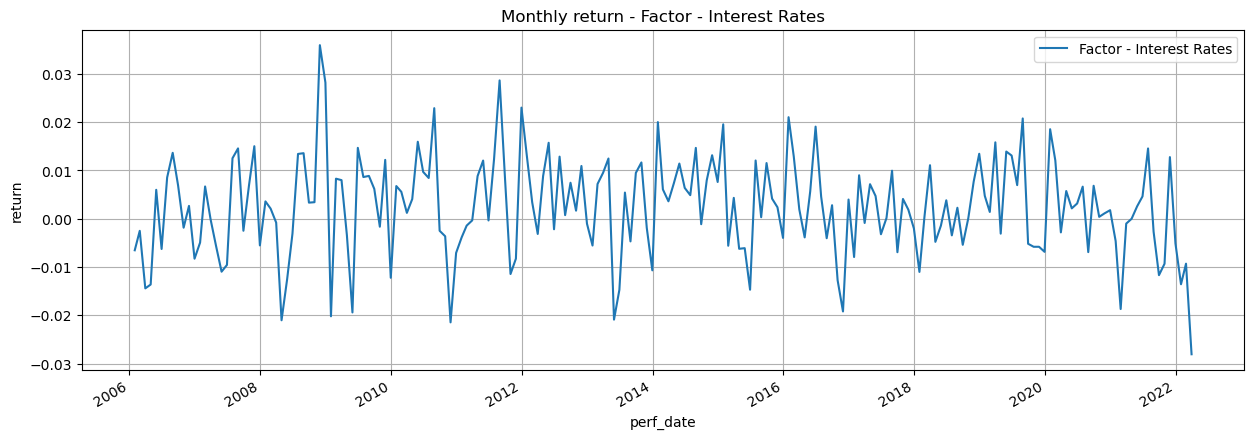

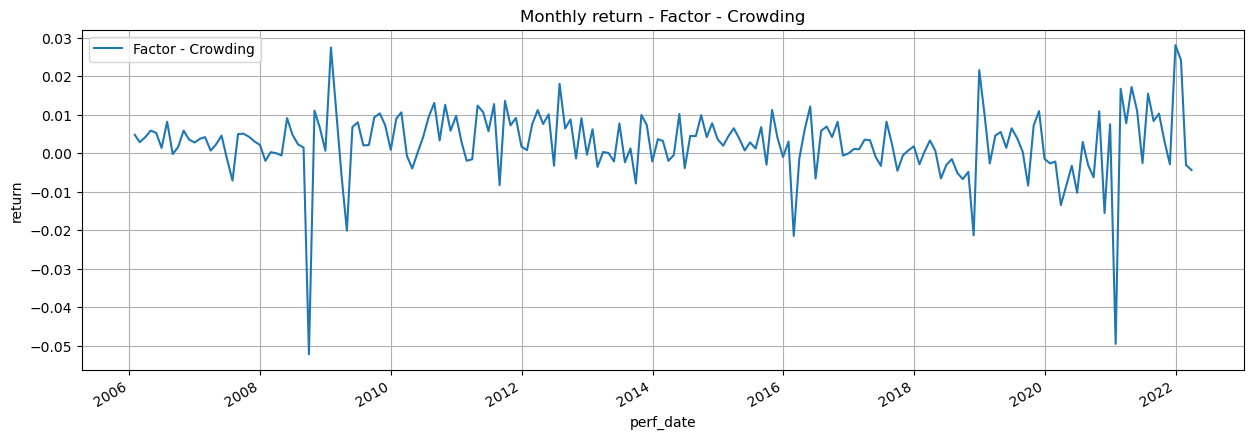

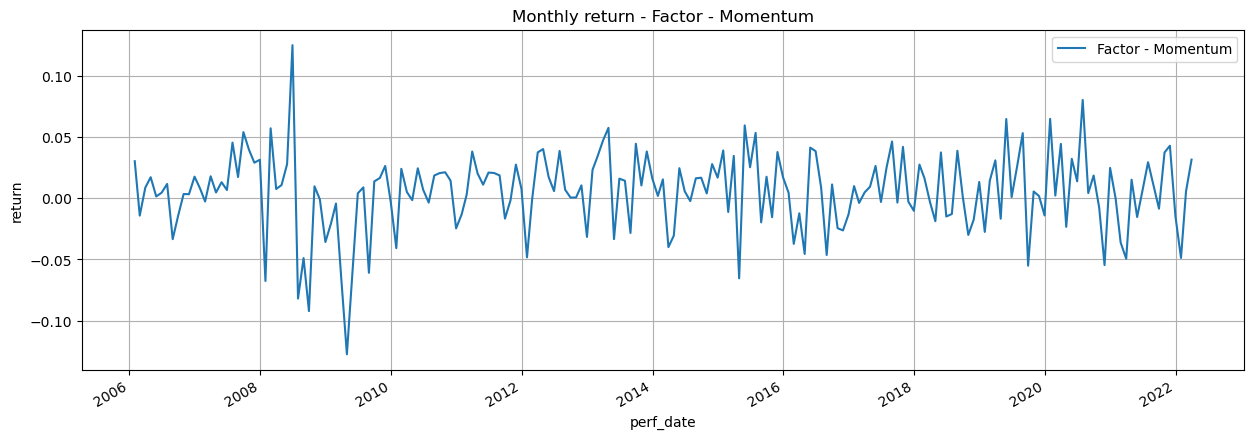

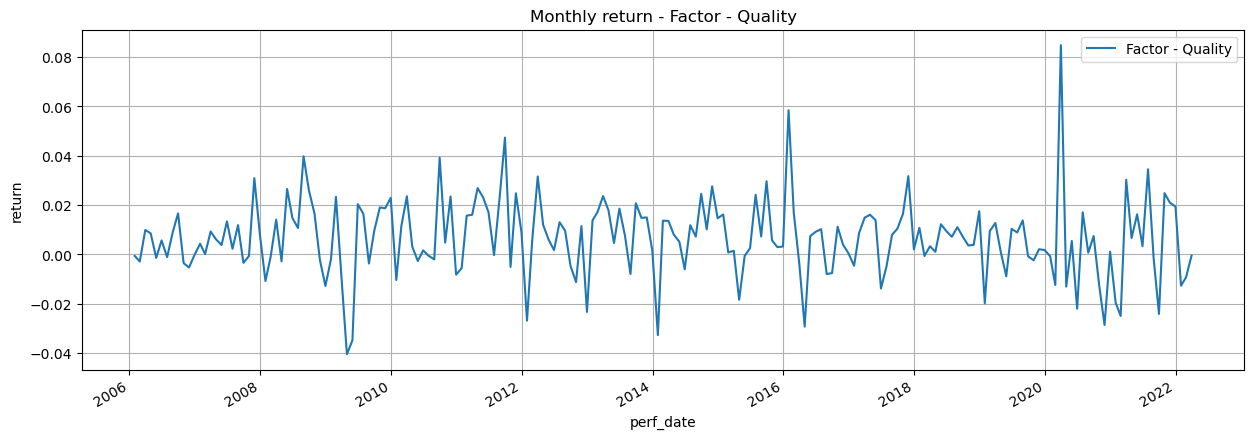

In [9]:
## Plot the time history of the monthly return of the hedge fund as well as each driving factor
for col in cleaned_return_df:
    plt.figure(figsize=(15,5))
    cleaned_return_df[col].plot()
    plt.ylabel('return')
    plt.title(f'Monthly return - {col}')
    plt.grid()
    plt.legend()

- all returns seem to centre around 0, and fluctuate with similar range of values.

In [10]:
## Use Augmented Dickey–Fuller test to check the stationarity of the test. Because the linear model should be 
## build using stationary features and targets.

from statsmodels.tsa.stattools import adfuller

adfuller_p_value_df = []
for col in cleaned_return_df:
    result = adfuller(cleaned_return_df[col])
    adfuller_p_value_df.append(
        result[1]
    )
adfuller_p_value_df = pd.DataFrame(
    adfuller_p_value_df, 
    index=cleaned_return_df.columns,
    columns=['p_value']
)

In [11]:
round(adfuller_p_value_df, 4)

p_value
Hedge Fund                            0.0
Factor - Low Risk                     0.0
Factor - Value vs Growth              0.0
Factor - Fixed Income Carry           0.0
Factor - Local Equity                 0.0
Factor - Trend Following              0.0
Factor - Commodities                  0.0
Factor - Equity                       0.0
Factor - Foreign Exchange Carry       0.0
Factor - Small Cap                    0.0
Factor - Emerging Markets             0.0
Factor - Foreign Currency             0.0
Factor - Local Inflation              0.0
Factor - Equity Short Volatility      0.0
Factor - Credit                       0.0
Factor - Interest Rates               0.0
Factor - Crowding                     0.0
Factor - Momentum                     0.0
Factor - Quality                      0.0

The p-values of all returnes from the test are less than some significance level (e.g., 0.05), which means that we can reject the null hypothesis and conclude that the time series is stationary with some confidence.

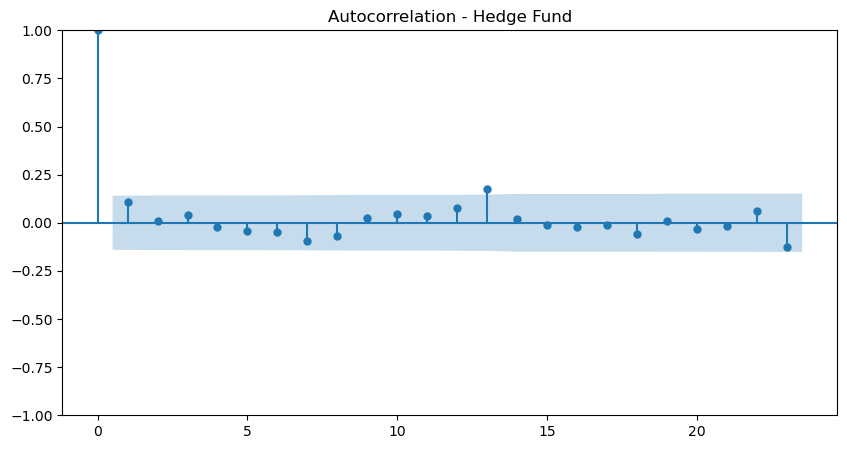

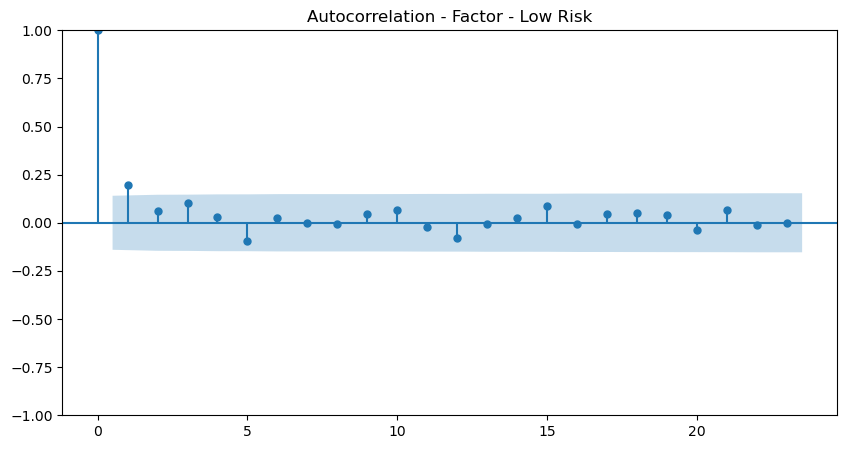

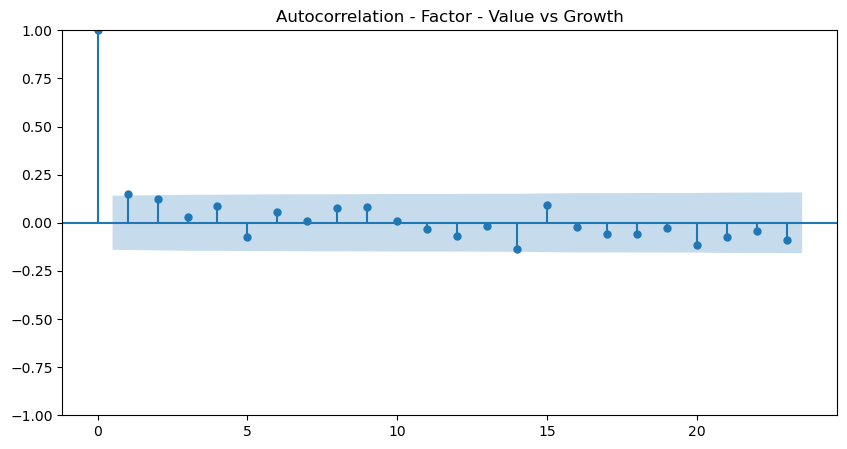

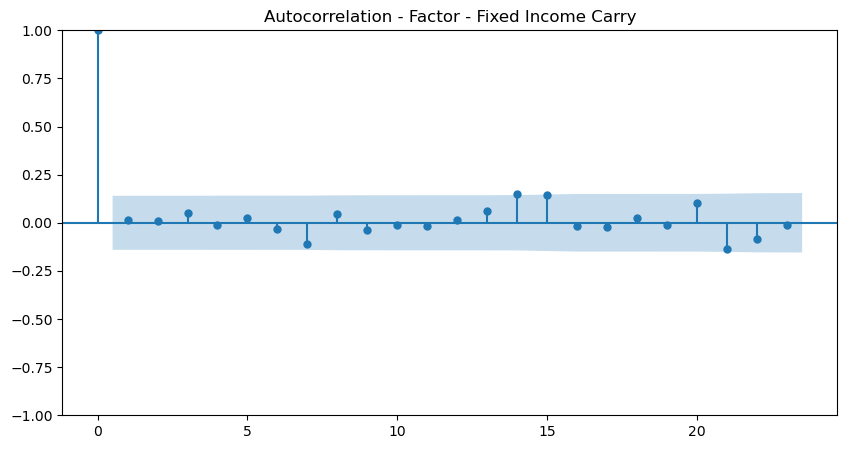

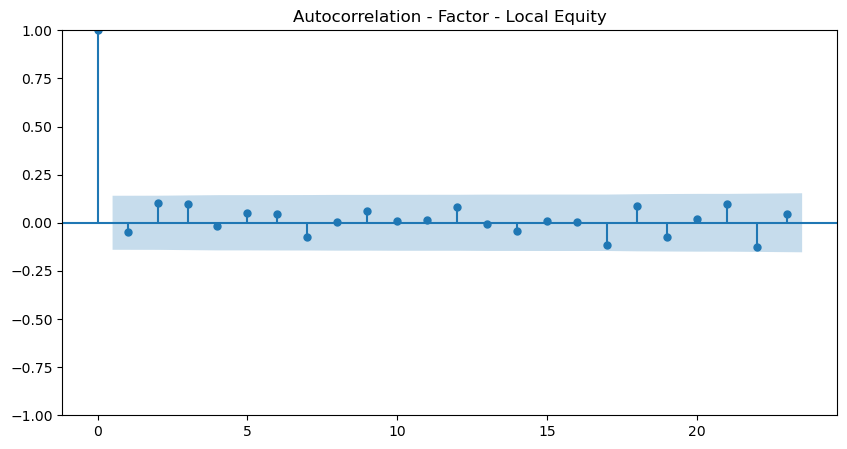

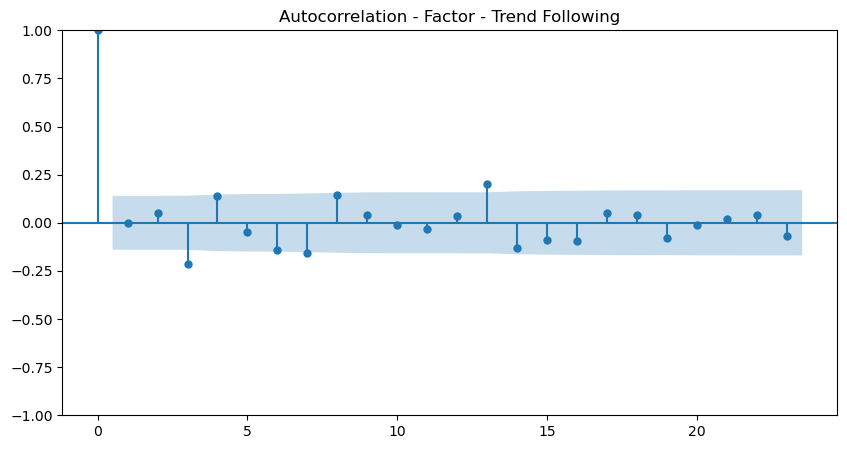

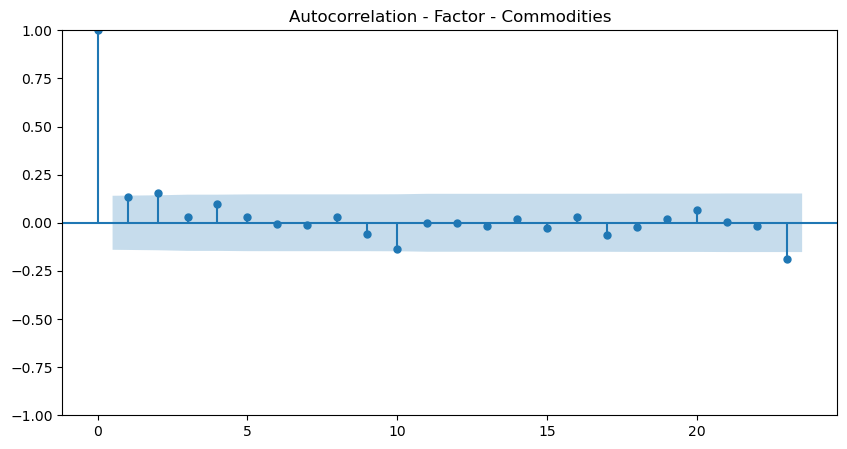

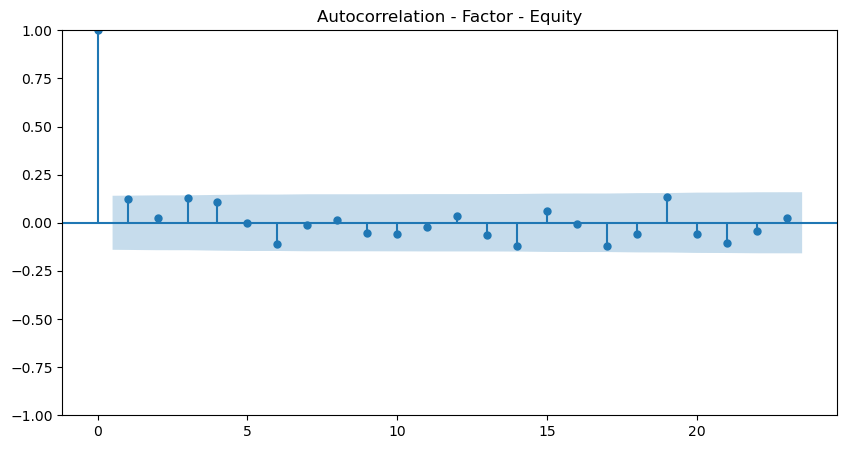

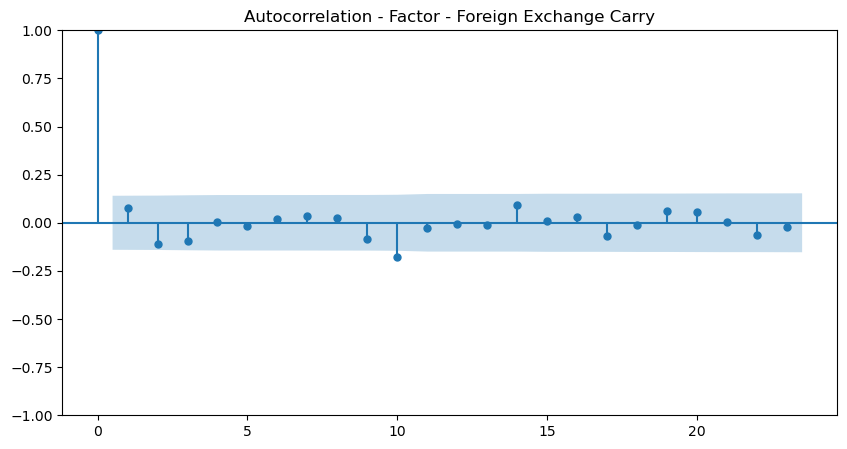

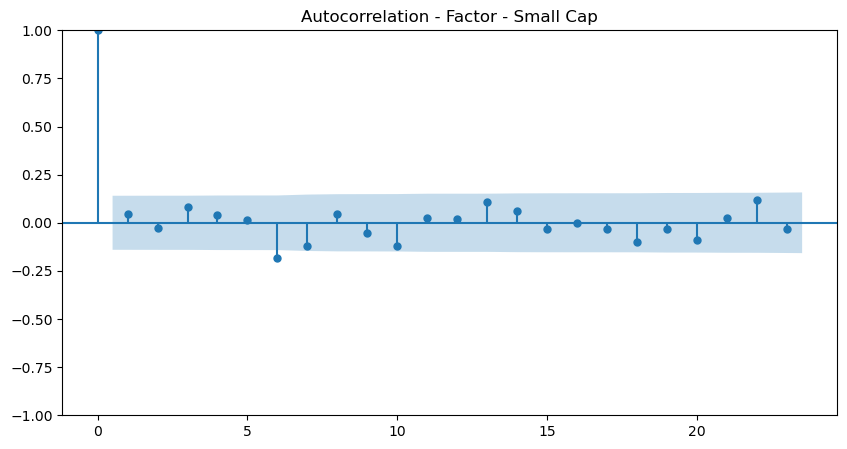

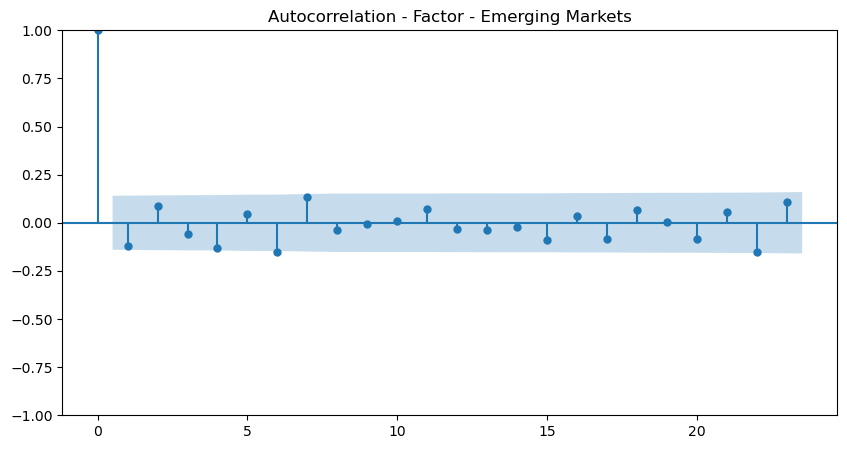

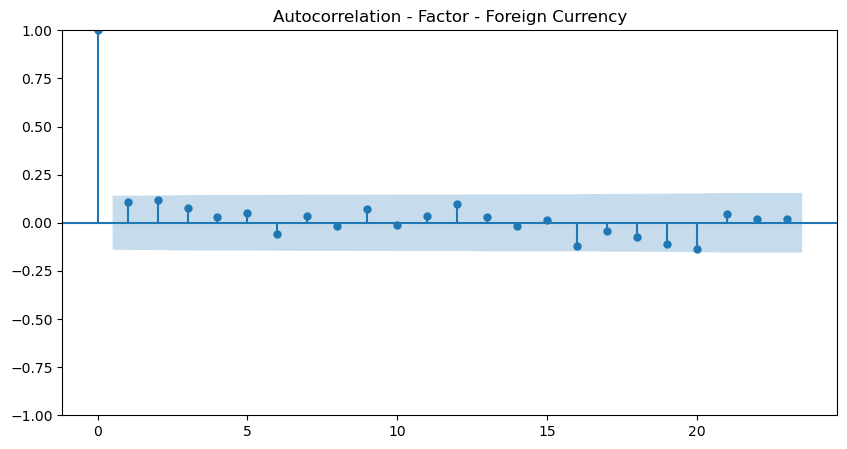

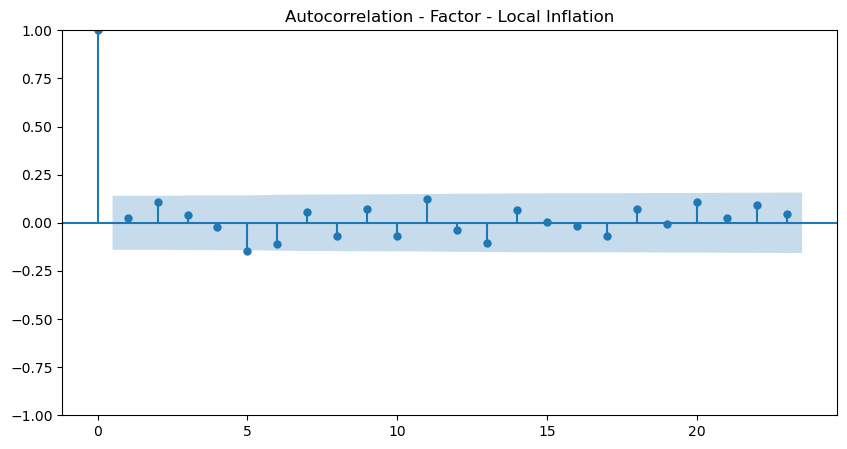

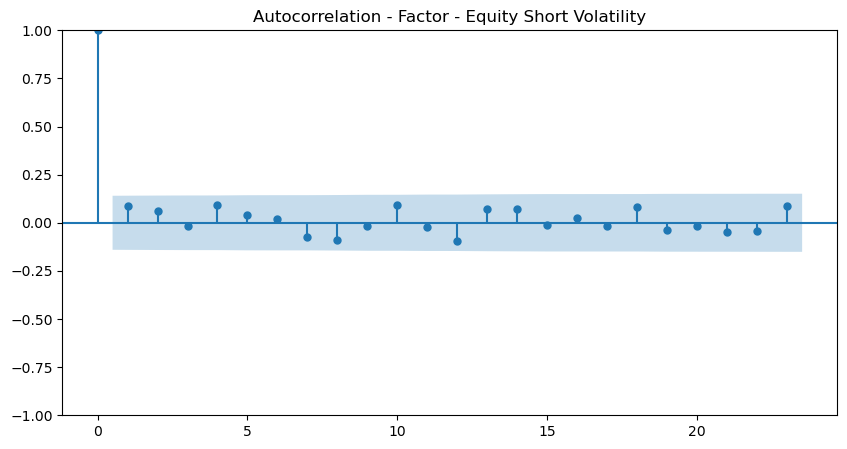

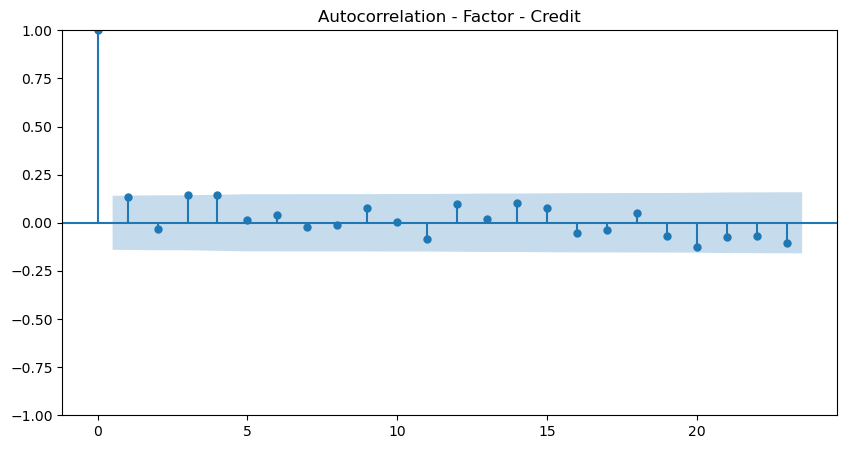

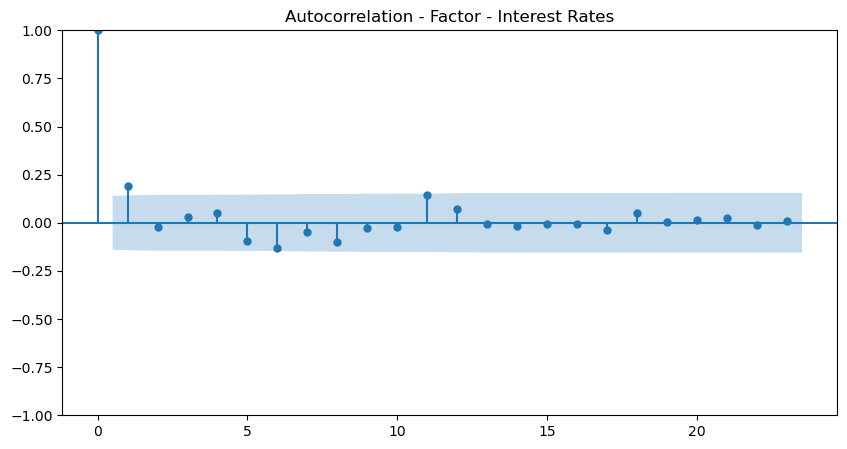

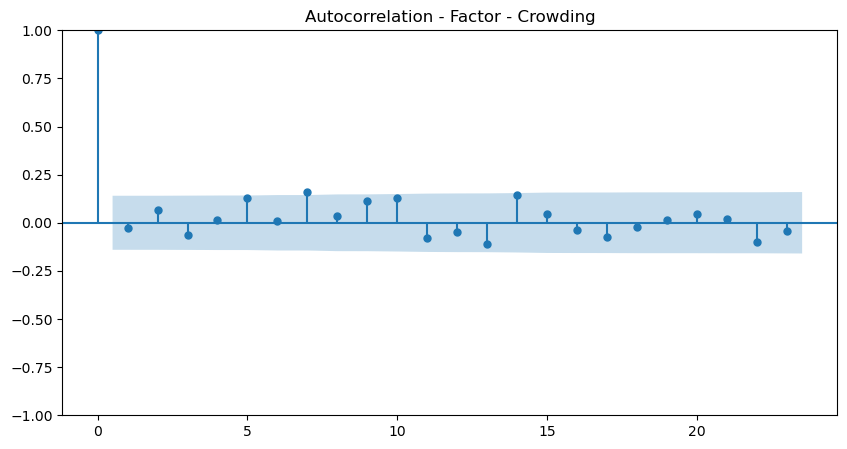

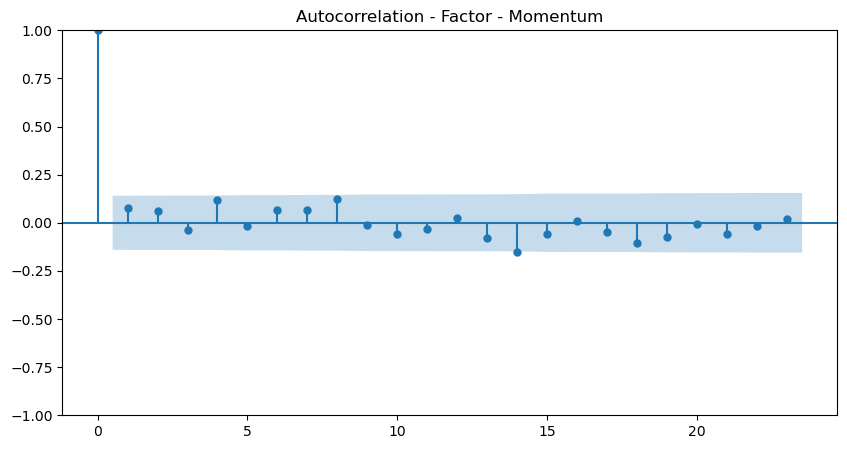

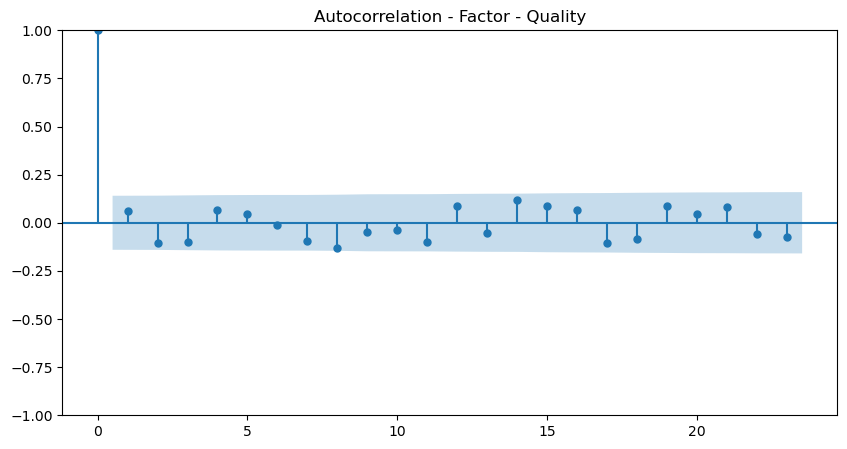

In [15]:
## Plot the autocorrelation for each timeseries to convince ourselves that are timeseries are stationary indeed

from statsmodels.graphics.tsaplots import plot_acf
for col in cleaned_return_df:
    acf2 = plot_acf(cleaned_return_df[col])
    acf2.set_figheight(5)
    acf2.set_figwidth(10)
    plt.title(f'Autocorrelation - {col}')
    plt.show()

 - The autocorrelation function declines to near zero rapidly for a stationary time series. However, in the case of each return plotted, the autocorrelation drops to a very low level very quickly, but hovers around the range between -0.1 and 0.1 afterwards. This means that the timeseries are not completely stationary.

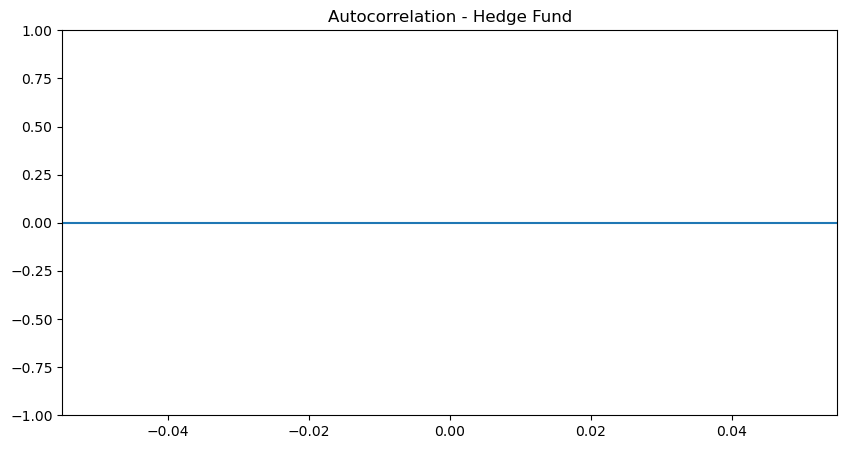

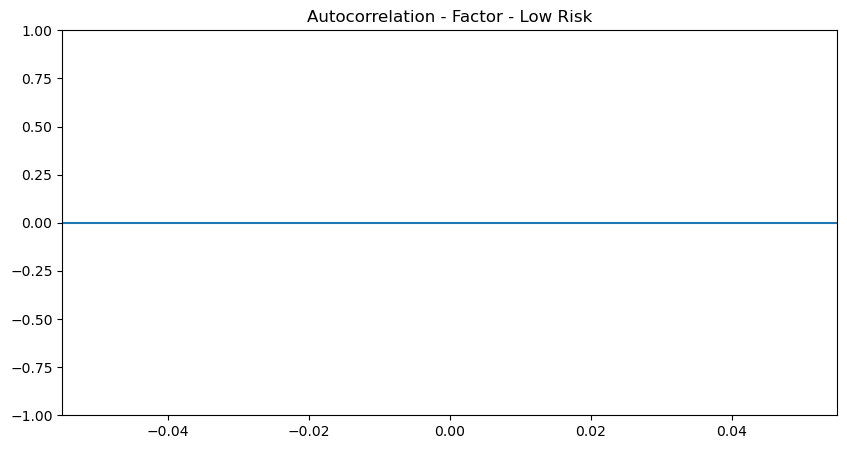

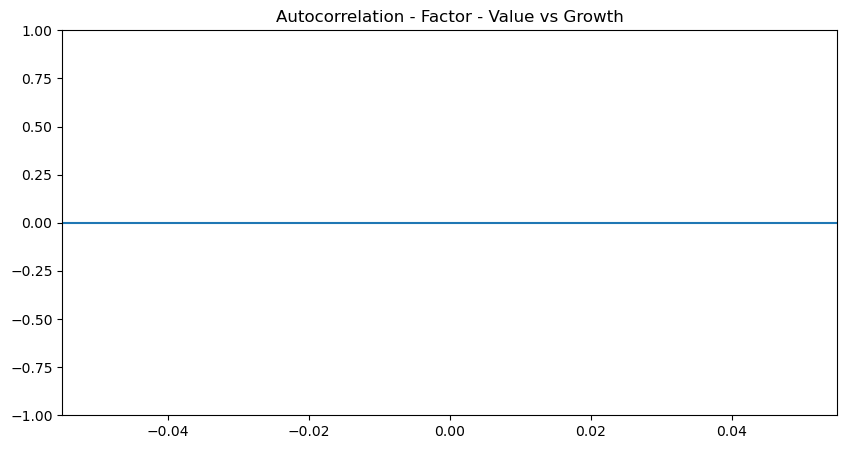

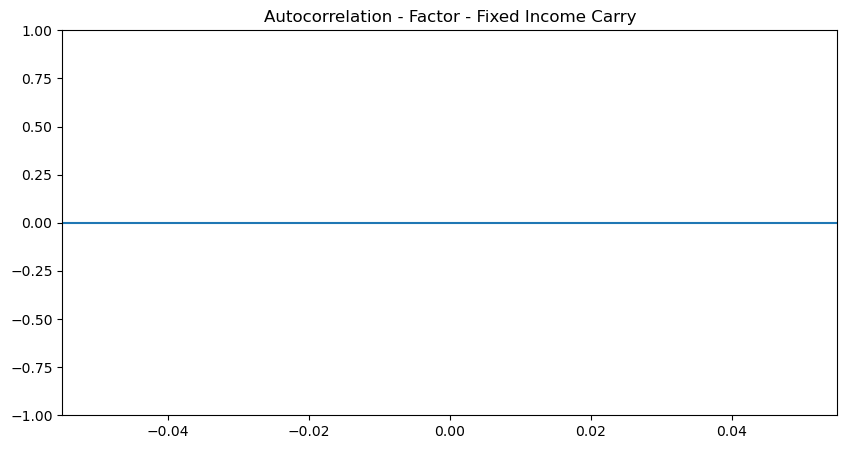

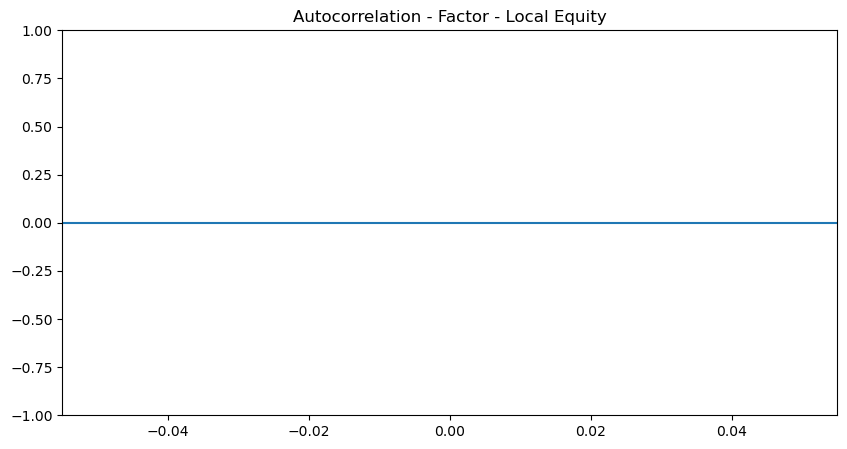

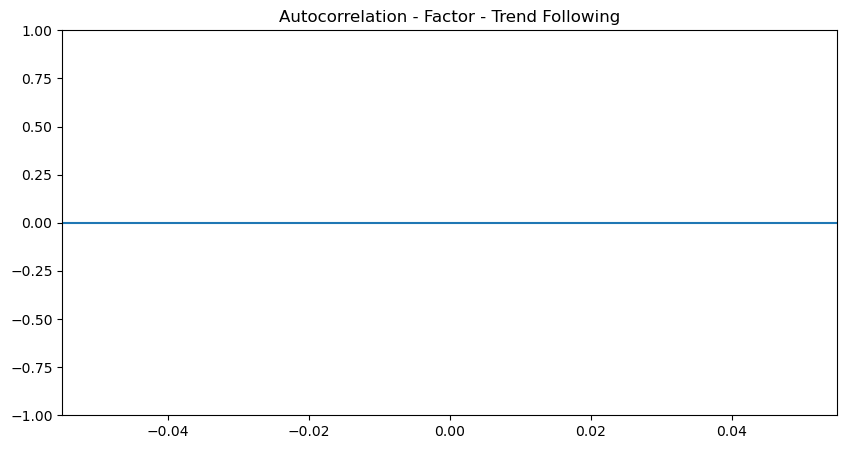

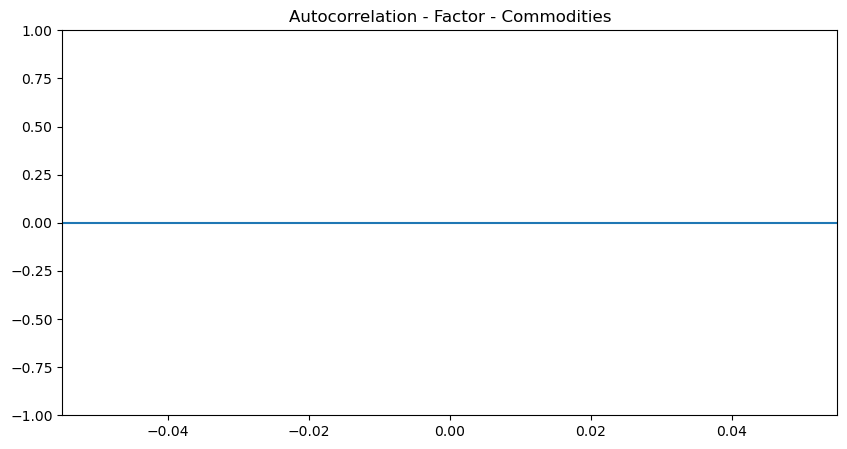

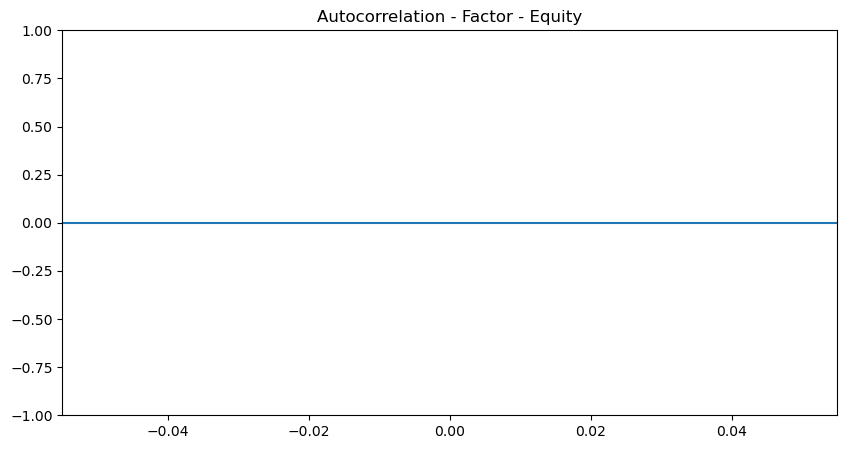

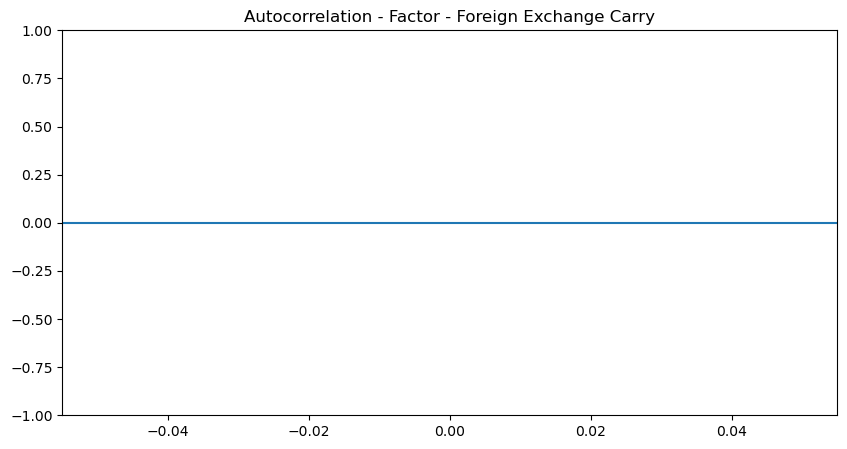

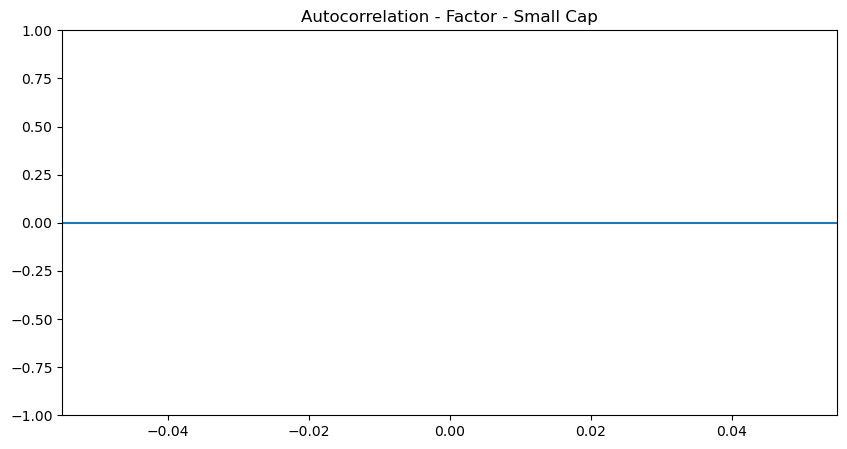

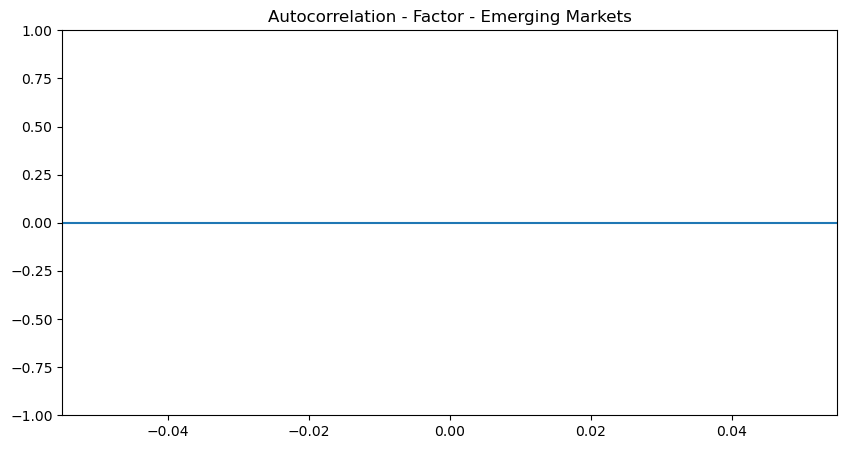

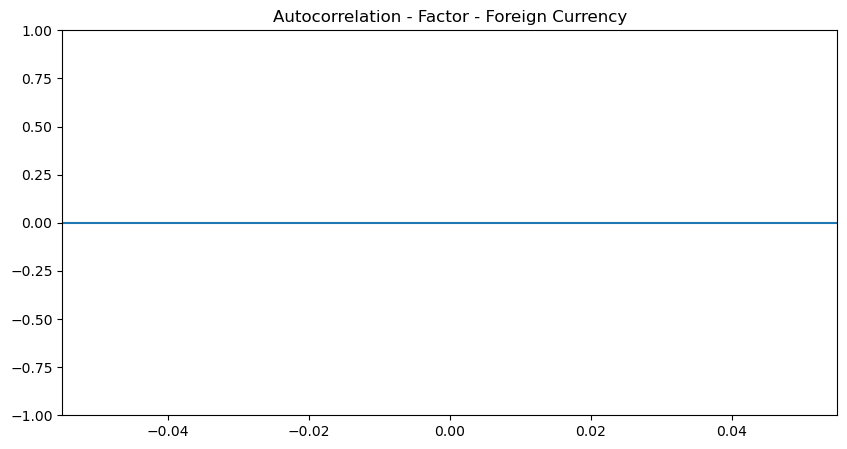

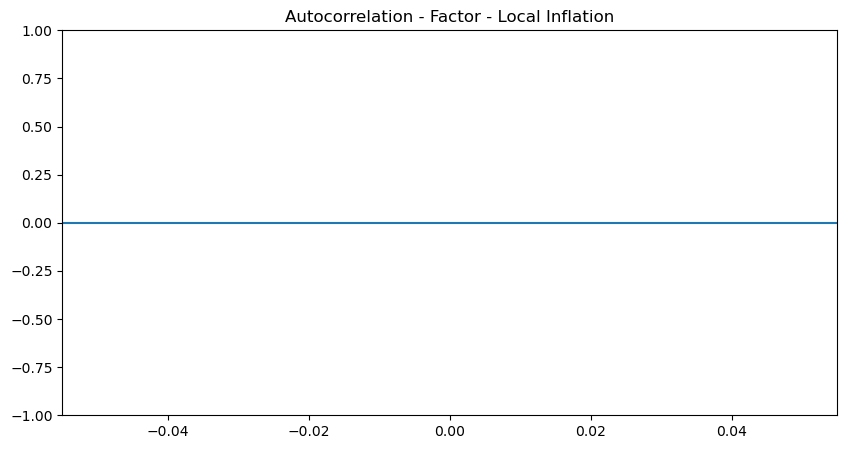

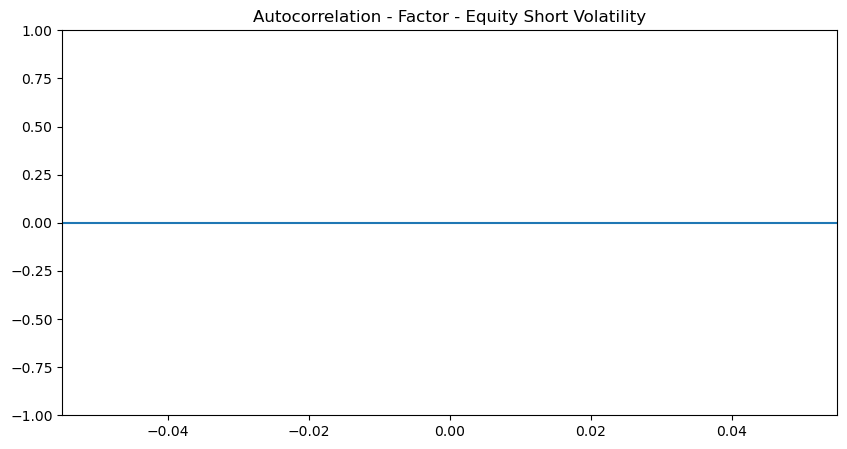

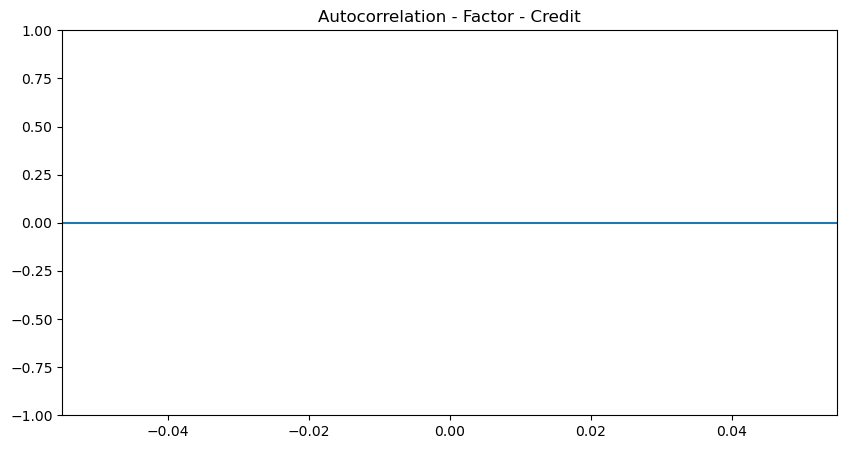

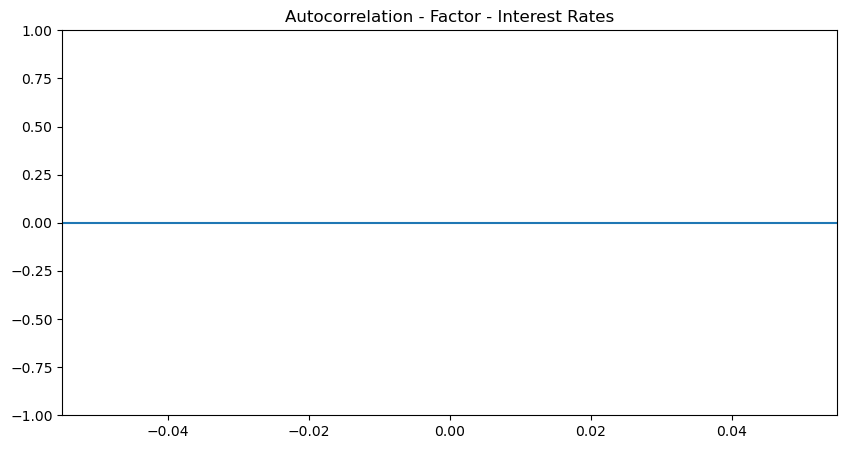

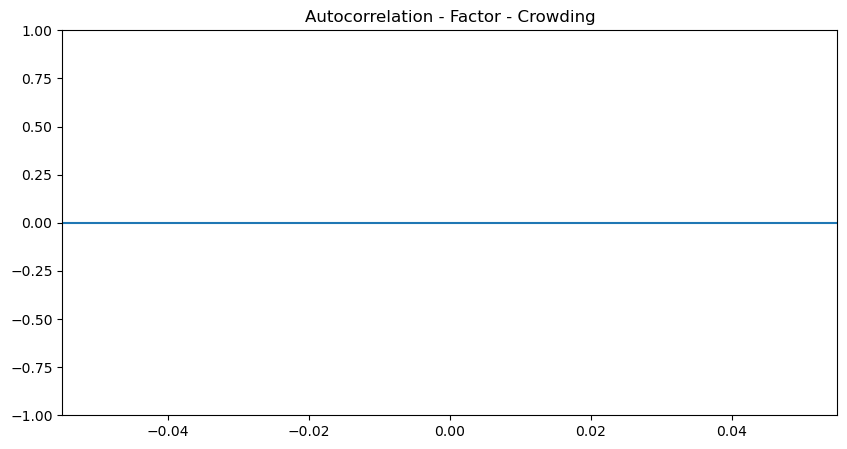

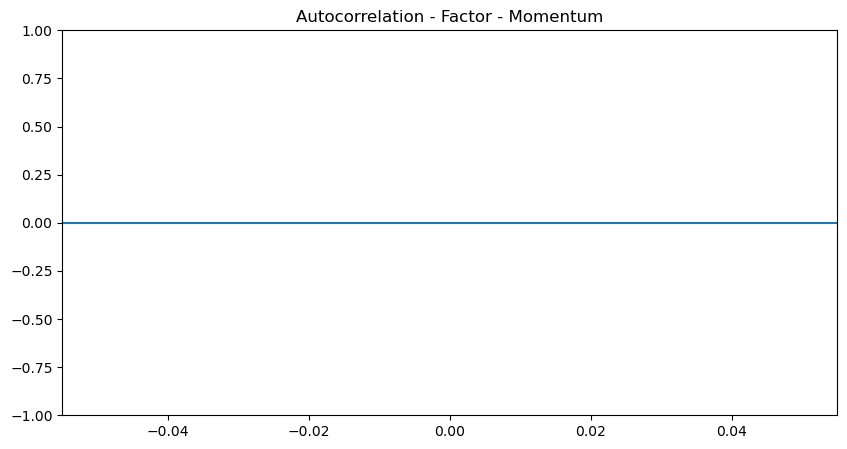

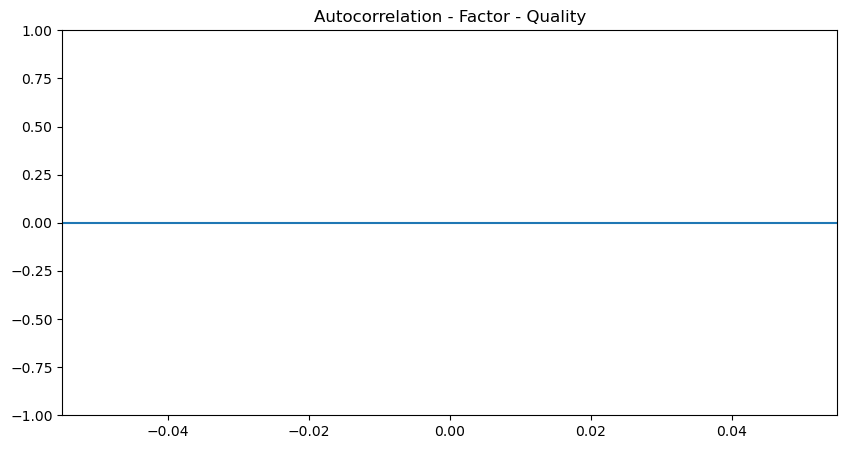

In [16]:
## Plot the autocorrelation for the monthly variation of return for each timeseries to see if they are completely stationary.
for col in cleaned_return_df:
    acf2 = plot_acf(cleaned_return_df[col].diff())
    acf2.set_figheight(5)
    acf2.set_figwidth(10)
    plt.title(f'Autocorrelation - {col}')
    plt.show()

- The timeseries have been stationarised by differencing the raw return series, whichs means that we can now assume the montly variation of returns is independent and identically distributed. Therefore, we are going to build a multilinear model with the montly variation of returns to estimate alpha and betas.

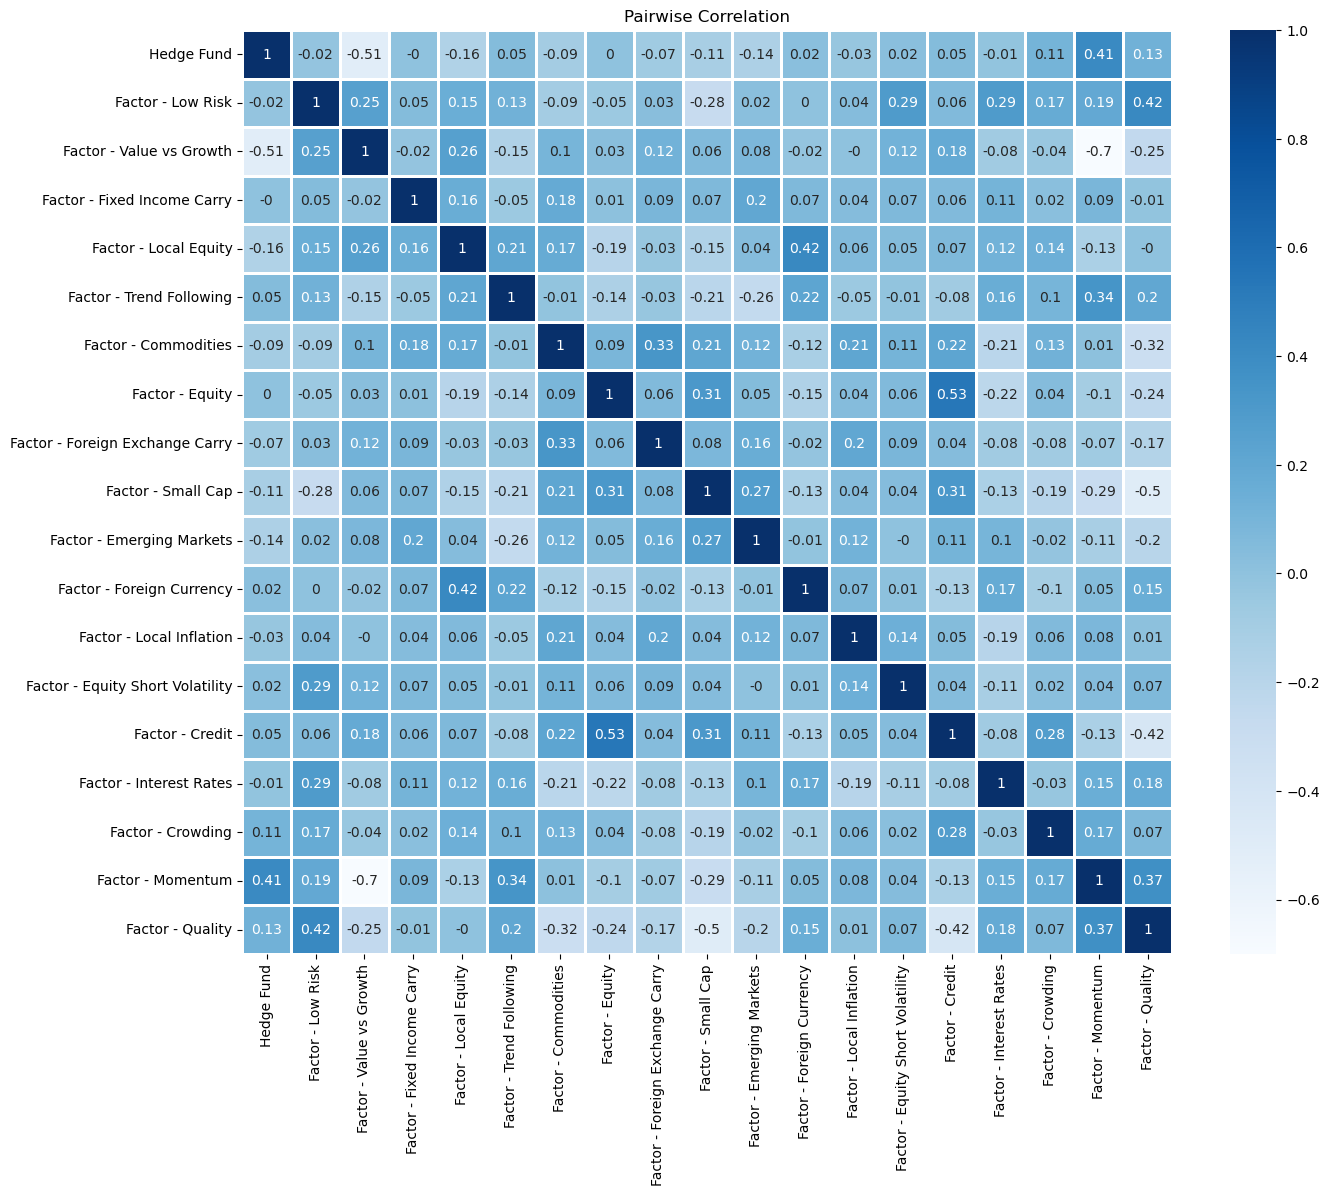

In [17]:
## Compute the pairwise Pearson correlation between the returns and visualise the result with a heatmap

return_corr = cleaned_return_df.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(
    round(return_corr, 2),
    annot=True,
    cmap='Blues',
    linewidth=0.9
)
plt.title('Pairwise Correlation')
plt.show();

- The heatmap above suggests that some factors are highly correlated with each other and some factors might not have predictive power at all in modelling the returns of the hedge fund. Therefore, feature selection and elimination is required before fitting the model to avoid overfitting and ensure the model fitted would be meaningful.

## Feature Selection

In [18]:
## Split the dataframe into the factors and the target, we are to use the former to model the latter.

target_df = cleaned_return_df[['Hedge Fund']]
factor_df = cleaned_return_df[
    cleaned_return_df.columns[
        cleaned_return_df.columns.str.startswith('Factor')
    ]
]

In [19]:
## Use mutual information to see what factors are predictive of the hedge fund. Although a linear
## model is to be fitted here, mutual information is more robust in identifying any relationship 
## (linear or non-linear) between two sets of i.d.d variables. 

from sklearn.feature_selection import mutual_info_regression

## Compute the mutual information between each factor and the hedge fund
mutual_info_df = pd.DataFrame(
    [
        mutual_info_regression(factor_df[[col]].values, target_df['Hedge Fund'].values)
        for col in factor_df.columns
    ],
    index=factor_df.columns,
    columns=['mutual_info']
)

## Sort the dataframe by the value of more information
mutual_info_df = mutual_info_df.sort_values(
    by='mutual_info', 
    ascending=False,
)

## Add Pearson correlation to the dataframe to compare its values with those given by mutual information
mutual_info_df['pearson_corr'] = return_corr['Hedge Fund'].loc[mutual_info_df.index]

In [20]:
mutual_info_df

mutual_info  pearson_corr
Factor - Value vs Growth             0.161760     -0.513356
Factor - Credit                      0.093361      0.049089
Factor - Commodities                 0.087490     -0.088907
Factor - Small Cap                   0.051632     -0.107134
Factor - Momentum                    0.044581      0.409925
Factor - Fixed Income Carry          0.039682     -0.004061
Factor - Local Inflation             0.022877     -0.030761
Factor - Emerging Markets            0.013774     -0.144234
Factor - Quality                     0.012606      0.133020
Factor - Trend Following             0.000757      0.054090
Factor - Foreign Exchange Carry      0.000000     -0.074095
Factor - Foreign Currency            0.000000      0.020700
Factor - Equity                      0.000000      0.001151
Factor - Equity Short Volatility     0.000000      0.015351
Factor - Interest Rates              0.000000     -0.008370
Factor - Crowding                    0.000000      0.112805
Factor - Local Equity                0.000000     -0.156394
Factor - Low Risk                    0.000000     -0.024927

In [21]:
## Set threshold to 0.01, any factor whose mutual information is below that threshold would
## be discarded because they are not very predictive of the targets.
filtered_mutual_info_df = mutual_info_df[
    (mutual_info_df['mutual_info'] > 0.01)
]

filtered_mutual_info_df

mutual_info  pearson_corr
Factor - Value vs Growth        0.161760     -0.513356
Factor - Credit                 0.093361      0.049089
Factor - Commodities            0.087490     -0.088907
Factor - Small Cap              0.051632     -0.107134
Factor - Momentum               0.044581      0.409925
Factor - Fixed Income Carry     0.039682     -0.004061
Factor - Local Inflation        0.022877     -0.030761
Factor - Emerging Markets       0.013774     -0.144234
Factor - Quality                0.012606      0.133020

Use recursive feature elimination with corss-validation to choose a set of the most informative features which gives the best performing Ridge regressor.

In [22]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import Ridge

def recursive_feature_elimination_with_Ridge_regression(
    train_feature_df,
    train_target_df,
    min_features_to_select=3,
    alpha=1e1, # for ridge regression
    cv=5, # for cross-validation in recursive feature elimination
    scoring=None,
):
    """
    This function performs recursive feature elimination with Ridge regression,
    then outputs the results in a dictionary.
    """
    
    print("""
    Performing recursive feature elimination with Ridge regression
    """)
    ridge_rfe = Ridge(alpha=alpha)

    ridge_rfecv = RFECV(
        estimator=ridge_rfe,
        step=1,
        cv=cv,
        min_features_to_select=min_features_to_select,
        scoring=scoring,
        n_jobs=-1,
    )
    ridge_rfecv.fit(
        train_feature_df,
        train_target_df
    )

    print(f"""
    Optimal number of features with Ridge regression: {ridge_rfecv.n_features_}
    """)
    
    return ridge_rfecv

In [23]:
## Differencing the raw return timeseries, the we are going to build the linear model for the variation of monthly return
diff_factor_df = factor_df[filtered_mutual_info_df.index].diff().dropna()
diff_target_df = target_df.diff().dropna()

## recursive feature elimination to select the best set of factors to use
ridge_rfecv = recursive_feature_elimination_with_Ridge_regression(
    diff_factor_df,
    diff_target_df,
    min_features_to_select=5,
    alpha=1e-1, # regularisation constant for ridge regression
    cv=5, # for the 5-fold cross-validation in recursive feature elimination
)


    Performing recursive feature elimination with Ridge regression
    

    Optimal number of features with Ridge regression: 7
    


In [24]:
## To check what factors have been selected
selected_factor_df = factor_df[ridge_rfecv.get_feature_names_out()]
diff_selected_factor_df = diff_factor_df[ridge_rfecv.get_feature_names_out()]
selected_factor_df

Factor - Value vs Growth  Factor - Credit  Factor - Small Cap  \
perf_date                                                                   
2006-01-31                 -0.012632         0.019915            0.025687   
2006-02-28                  0.012010         0.003766           -0.005889   
2006-03-31                 -0.001646         0.000358            0.012512   
2006-04-30                  0.002147         0.008849           -0.007250   
2006-05-31                  0.019188        -0.000345           -0.015368   
...                              ...              ...                 ...   
2021-11-30                  0.005199        -0.020208           -0.013525   
2021-12-31                  0.044041         0.005231           -0.013187   
2022-01-31                  0.126823        -0.004313           -0.025739   
2022-02-28                  0.011823        -0.025138            0.025021   
2022-03-31                  0.011146         0.002544           -0.011433   

            Factor - Momentum  Factor - Fixed Income Carry  \
perf_date                                                    
2006-01-31           0.030207                     0.006403   
2006-02-28          -0.014214                    -0.021316   
2006-03-31           0.008646                    -0.006682   
2006-04-30           0.017130                     0.020273   
2006-05-31           0.001438                     0.029589   
...                       ...                          ...   
2021-11-30           0.042852                    -0.015835   
2021-12-31          -0.014906                     0.034074   
2022-01-31          -0.048792                     0.006461   
2022-02-28           0.005495                     0.000429   
2022-03-31           0.031501                    -0.032017   

            Factor - Local Inflation  Factor - Emerging Markets  
perf_date                                                        
2006-01-31                  0.009925                   0.022615  
2006-02-28                 -0.005564                   0.023366  
2006-03-31                  0.015684                  -0.039254  
2006-04-30                  0.026725                  -0.006414  
2006-05-31                  0.016301                  -0.054605  
...                              ...                        ...  
2021-11-30                  0.044356                   0.021728  
2021-12-31                 -0.030489                  -0.008817  
2022-01-31                  0.038181                   0.013059  
2022-02-28                  0.027307                  -0.040556  
2022-03-31                 -0.006009                  -0.016588  

[195 rows x 7 columns]

## Multi-linear Model with Ridge Regression
- Since the purpose of this task is not timeseries forecasting and given the size of the dataset provided, I decided not split the data into a train set and a test set.
- Instead, I used the bootstrap method to train an ensemble of regressors and then assessed the reliability of the models output by looking at the distribution of their coefficients obtained.

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

def get_bootstrap_ridge_regressors(
    N, # number of rounds of sampling and getting estimators,
    X, # features
    Y, # targets
    test_szie=0.3, # test size for train test split
    alpha=1e-3, # regularisation constant for ridge regression
    fit_intercept=True, # for ridge regression
) -> dict:
    """
    This function would train a set of Ridge regressors with the datasets obtaiend by randomly 
    spliting X and Y into train and test sets (random sampling with replacement), then outputs the estimators 
    and their performance scores as per measured by mean sqaured error on the test set and goodness-of-fit 
    measured by r2 score.
    """
    data_dict = {}
    r2_scores = []
    test_MSE = []
    ridge_estimators = {}
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            Y, 
            test_size=test_szie,
        )
        data_dict[i] = X_train, X_test, y_train, y_test
        
        # get the i_th ridge regressor
        ridge_i = Ridge(
            alpha=alpha,
            fit_intercept=fit_intercept,
        )
        ridge_i.fit(X_train, y_train)
        ridge_pred_i = ridge_i.predict(X_test)
        r2_scores.append(
            r2_score(y_test, ridge_pred_i)
        )
        MSE = ((y_test.values.flatten() - ridge_pred_i.flatten()) ** 2).mean()
        test_MSE.append(MSE)
        ridge_estimators[i] = ridge_i

    return {
        'data_dict': data_dict,
        'r2_scores': np.array(r2_scores),
        'test_MSE': np.array(test_MSE),
        'ridge_estimators': ridge_estimators,
    }

In [26]:
ridge_outputs = get_bootstrap_ridge_regressors(
    N=1000, # number of rounds of sampling and getting estimators,
    X=diff_selected_factor_df, # features
    Y=diff_target_df, # targets
    test_szie=0.3, # test size for train test split
    alpha=1e-1, # regularisation constant for ridge regression
    fit_intercept=False,
)

In [27]:
## collate dataframes with gradients(beta) of each factor from all ridge regressors output
beta_df = []
for i, ridge_reg in ridge_outputs['ridge_estimators'].items():
    beta_df.append(ridge_reg.coef_.flatten())
beta_df = pd.DataFrame(beta_df, columns=selected_factor_df.columns)

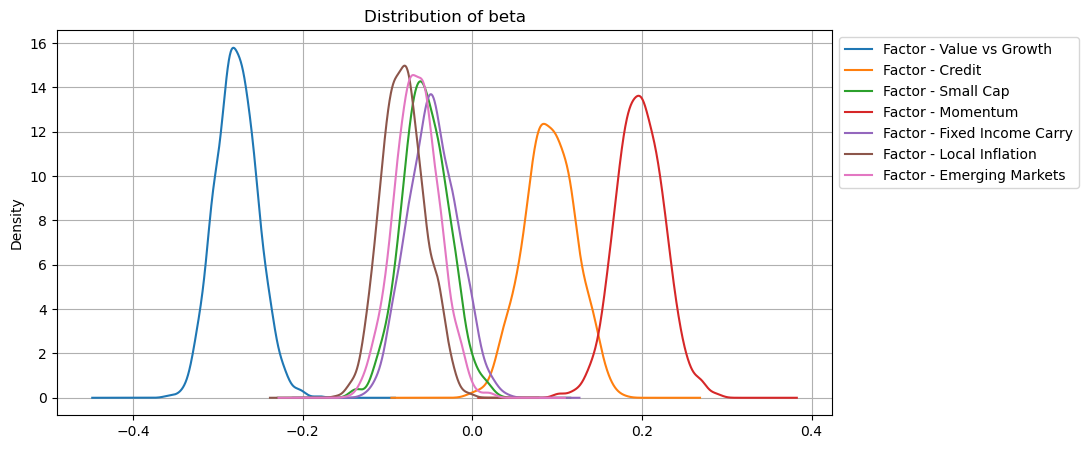

In [28]:
## Plot the distributions of the beta of each factor against the target - Hedge Fund
beta_df.plot.kde(figsize=(10, 5))
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Distribution of beta');

- The KDE plots above suggests that we can more confident about the robustness of the models by looking at distributions of the coefficients, i.e., similar models were returned when different data had been used to train them. Such distributions could also form the basis of Bayesian analysis of the model, which could be another source for exploration. 
- The distributions above also imply that overfitting had not occurred - a common phenomenon when overfitting occurs is that the coefficient of each variables which are correlated with some other variables is that they would have a very spread-out or even a bimodal distribution.
- The beta of each factor relative to the hedge fund is the average of the values output by each regression, as given below. All other factors not listed here are considered to have a zero or negligible beta relative to the hedge fund. 

In [29]:
beta_df.mean()

Factor - Value vs Growth      -0.278062
Factor - Credit                0.091117
Factor - Small Cap            -0.055388
Factor - Momentum              0.197558
Factor - Fixed Income Carry   -0.046500
Factor - Local Inflation      -0.080875
Factor - Emerging Markets     -0.065452
dtype: float64

In [31]:
## To calculate the alpha of the hedge fund with the betas obtained earlier.

## Given the linear model - hedge_fund = alpha + beta * factor
## First calculate the second on the right hand side of the equation above
raw_pred_df = selected_factor_df.multiply(
    beta_df.mean(),
    axis=1
).sum(axis=1)

## The alpha is them simply the averaged value of the difference between the target and term calculated above
alpha = (target_df['Hedge Fund'] - raw_pred_df).mean()


## Therefore the modelled return using the factors would be 
pred_df = raw_pred_df + alpha

print(f'The alpha of the hedge fund over the factors selected is {alpha}')

The alpha of the hedge fund over the factors selected is 0.007226889614273094


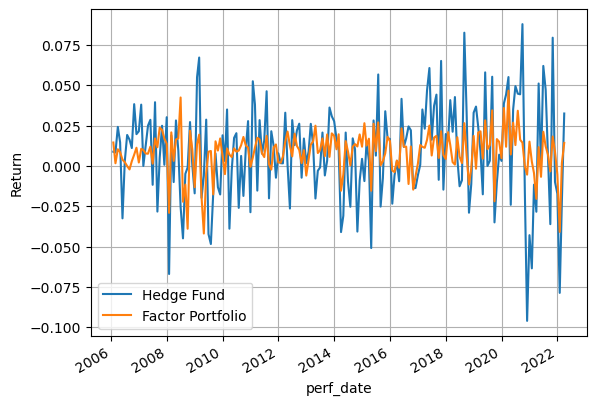

In [35]:
## Plot the modelled portfolio return again the return of the hedge fund

target_df.plot(label='Hedge Fund')
pred_df.plot(label='Factor Portfolio')
plt.ylabel('Return')
plt.legend(loc='best')
plt.grid()

- The time history of the returns of the factor portfolio does not exactly match those of the hedge fund, though their overall trend do share a similar pattern and the factor portfolio is a lot less volatile.

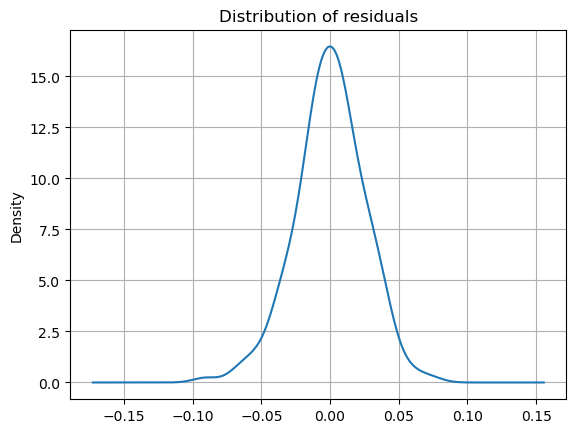

In [36]:
## Compute the residuals of the model and visualise its distribution.

residual_df = target_df['Hedge Fund'] - pred_df

residual_df.plot.kde()
plt.grid()
plt.title('Distribution of residuals');

- the distribution of the residuals is close enough to that of a normal distribution, which suggests that the linear model trained has done reasonably good job at modelling the return pattern of the hedge fund using the factors selected.

## Hedge Fund vs Factor Portfolio

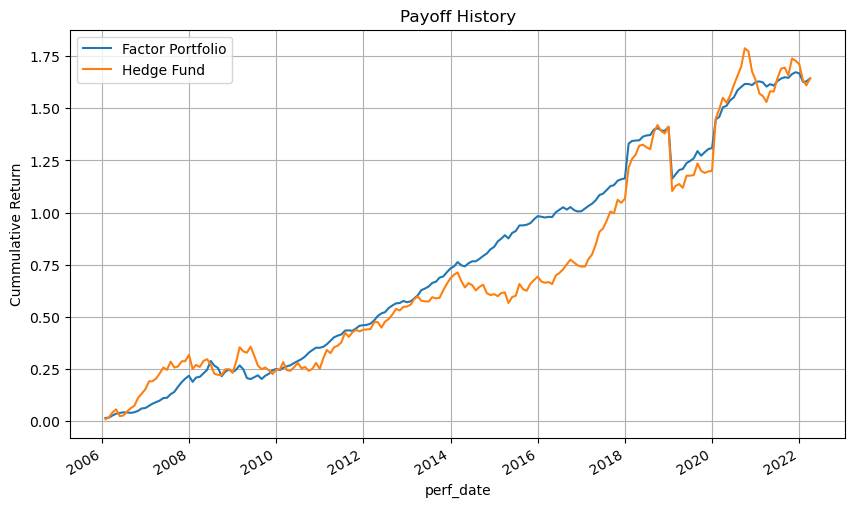

In [47]:
## Plot the payoff history of the hedge fund and the factor portfolio constructed with the linear model
pred_df.cumsum().plot(
    label='Factor Portfolio', 
    figsize=(10, 6)
)
target_df['Hedge Fund'].cumsum().plot(
    label='Hedge Fund'
)
plt.title('Payoff History')
plt.ylabel('Cummulative Return')
plt.legend()
plt.grid();

- The chart suggests that a portfolio which follows the payoff history can be constructed with some of the factors provided. Such a factor portfolio can lead to similar level of return without having to pay the management fees applied by the fund manager. 

In [66]:
## Calculate following risk-vs-rewards metrics to further to assess the risk level of each investment stratgy

def sharpe_ratio(
    df: Union[pd.DataFrame, pd.Series], 
    N=255, # 255 trading days in a year
):
    """
    This function computes the annualised Sharpe ratio given a timeseries
    """
    mean = df.mean() * N 
    sigma = df.std() * np.sqrt(N)
    return mean / sigma


def sortino_ratio(
    df: Union[pd.DataFrame, pd.Series], 
    N=255, # 255 trading days in a year
):
    """
    This function computes the annualised Sortino ratio given a timeseries
    """
    mean = df.mean() * N
    sigma_neg = df.loc[df < 0].std() * np.sqrt(N)
    return mean / sigma_neg


def max_drawdown(
    df: Union[pd.DataFrame, pd.Series], 
):
    """
    This function computes the max drawdown given a timeseries
    """
    commulative_return = df.cumsum()
    peak = commulative_return.expanding(min_periods=1).max()
    drawdown = commulative_return / peak - 1
    return drawdown.min()


def calmar_ratio(
    df: Union[pd.DataFrame, pd.Series],
    N=255, # 255 trading days in a year
):
    """
    This function computes the Calmar Ratio given a timeseries
    """
    return N * df.mean(axis=0) / abs(max_drawdown(df))

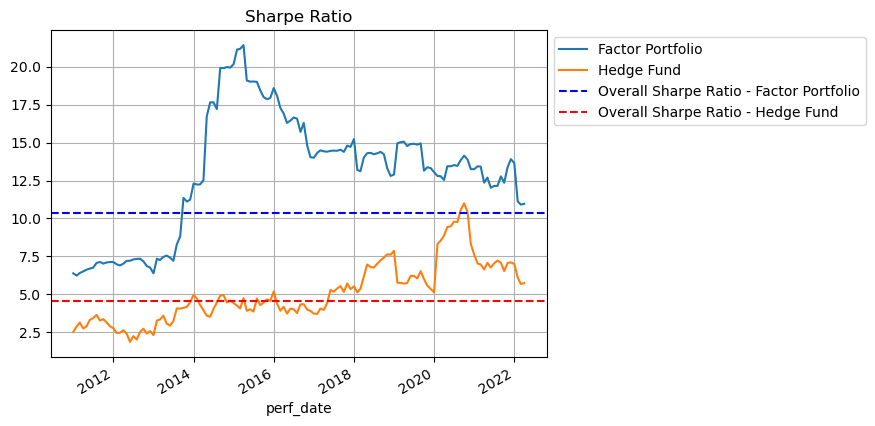

In [54]:
window = 60 # a 5-year window
pred_df.rolling(window=window).apply(sharpe_ratio).dropna().plot(label='Factor Portfolio')
target_df['Hedge Fund'].rolling(window=window).apply(sharpe_ratio).dropna().plot(label='Hedge Fund')
plt.title('Sharpe Ratio')
plt.axhline(
    y=sharpe_ratio(pred_df),
    color='b', 
    linestyle='--',
    label='Overall Sharpe Ratio - Factor Portfolio',
)
plt.axhline(
    y=sharpe_ratio(target_df['Hedge Fund']), 
    color='r', 
    linestyle='--',
    label='Overall Sharpe Ratio - Hedge Fund'
)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

The chart above shows that not only does the Factor Portfolio has a higher overall Sharpe ratio (10.362) than the Hedge Fund (4.542), but it is also consistently the case throughout history. This is not surprising given that they have very similar level of return overtime but the factor portfolio has a much less volatile payoff history.

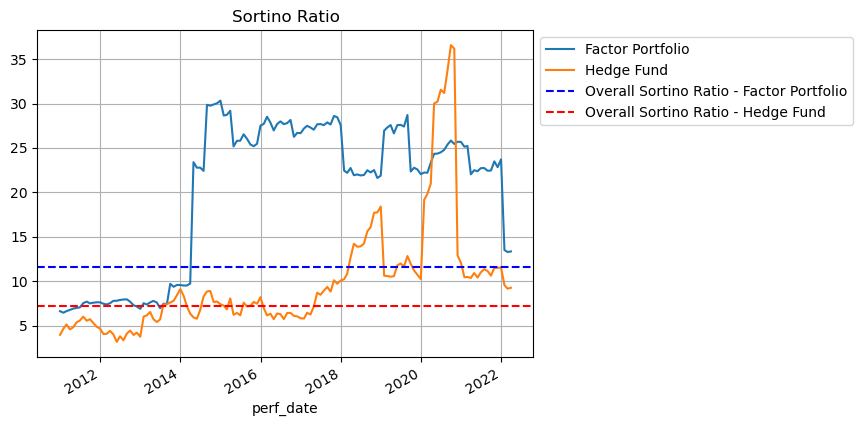

In [57]:
window = 60
pred_df.rolling(window=window).apply(sortino_ratio).dropna().plot(label='Factor Portfolio')
target_df['Hedge Fund'].rolling(window=window).apply(sortino_ratio).dropna().plot(label='Hedge Fund')
plt.title('Sortino Ratio')
plt.axhline(
    y=sortino_ratio(pred_df),
    color='b', 
    linestyle='--',
    label='Overall Sortino Ratio - Factor Portfolio',
)
plt.axhline(
    y=sortino_ratio(target_df['Hedge Fund']), 
    color='r', 
    linestyle='--',
    label='Overall Sortino Ratio - Hedge Fund'
)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

The Factor Portfolio has a higher overall Sortino Ratio (11.636) compared to the Hedge Fund (7.235). This holds true for most of time except that period from 2020 to 2021, during which the Hedge Fund has performed better in terms of accumulative return and consequently lead to a temporarily higher Sortino ratio.

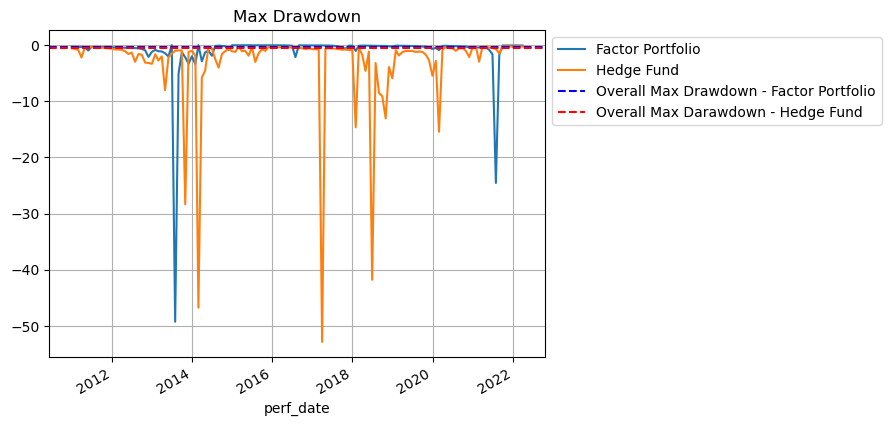

In [67]:
window = 60
pred_df.rolling(window=window).apply(max_drawdown).dropna().plot(label='Factor Portfolio')
target_df['Hedge Fund'].rolling(window=window).apply(max_drawdown).dropna().plot(label='Hedge Fund')
plt.title('Max Drawdown')
plt.axhline(
    y=max_drawdown(pred_df),
    color='b', 
    linestyle='--',
    label='Overall Max Drawdown - Factor Portfolio',
)
plt.axhline(
    y=max_drawdown(target_df['Hedge Fund']), 
    color='r', 
    linestyle='--',
    label='Overall Max Darawdown - Hedge Fund'
)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

The Factor Portfolio has a higher overall Max Drawdown (-0.301) compared to the Hedge Fund (-0.581). This is also true for most of the history considered except when there is a spike occur for the Factor Portfolio. However, the Hedge Fund has a lot more downward spike through time due to its more volatile payoff history.

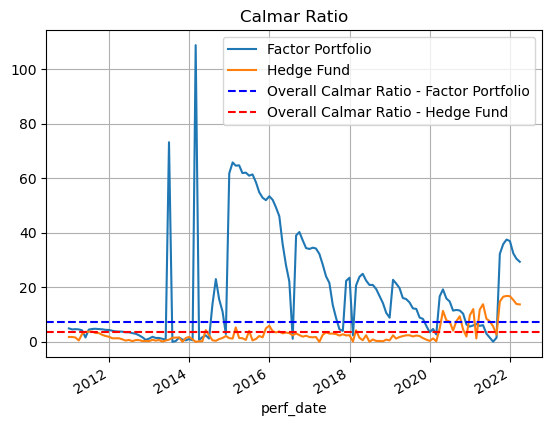

In [68]:
window = 60
pred_df.rolling(window=window).apply(calmar_ratio).dropna().plot(label='Factor Portfolio')
target_df['Hedge Fund'].rolling(window=window).apply(calmar_ratio).dropna().plot(label='Hedge Fund')
plt.title('Calmar Ratio')
plt.axhline(
    y=calmar_ratio(pred_df),
    color='b', 
    linestyle='--',
    label='Overall Calmar Ratio - Factor Portfolio',
)
plt.axhline(
    y=calmar_ratio(target_df['Hedge Fund']), 
    color='r', 
    linestyle='--',
    label='Overall Calmar Ratio - Hedge Fund'
)
plt.legend(bbox_to_anchor=(1, 1))
plt.grid()

The Factor Portfolio has a higher overall Calmar Ratio (7.140) compared to the Hedge Fund (3.795), which is also true for most part of the history. This is expected given the similar level of return but the Factor Portfolio has a lower Max Drawdown most of the time.

Having looked at 4 risk-vs-reward metrics as well as the payoff history through time, it can be concluded that the Hedge Fund is the riskier strategy. Given the level of return is similar, investing in the Factor Portfolio is the better course of actio - lower risk and no management fees.

## Stationarity of Beta

The analyses presented above has assumed a stationary beta between each factor used to the hedge fund portfolio. So it is important to look at if this is indeed the case through to validate this assumption. 

In [61]:
def get_rolling_ridge_regressors(
    window: int,
    alpha: float,
    X: pd.DataFrame,
    y: pd.DataFrame,
    fit_intercept=True,
) -> dict:
    """
    This function performs rolling Ridge regreesion between X and y with a window width and 
    a regularisation constant specified, then outputs a dictioanry containing the regressors 
    and a dataframe showing the betas obtained vary through time.
    """
    i = 0
    rolling_Ridge_reg = {}
    rolling_beta = []
    while i + window < len(y):
        # get the features and target within the window 
        rolling_X = X.iloc[i:i+window, :]
        rolling_y = y.iloc[i:i+window, :]
        # train the Ridge regressor
        ridge_reg = Ridge(
            alpha=alpha,
            fit_intercept=fit_intercept,
        )
        ridge_reg.fit(
            rolling_X, 
            rolling_y,
        )
        # store the regressor trained in the dictionary and record the beta it gives
        rolling_Ridge_reg[rolling_y.index[-1]] = ridge_reg
        rolling_beta.append(
            ridge_reg.coef_.flatten()
        )
        i += 1
    # collate the dataframe with the history of beta obtained by rolling regression performed
    rolling_beta_df = pd.DataFrame(
        rolling_beta,
        index=rolling_Ridge_reg.keys(),
        columns=diff_selected_factor_df.columns
    )
    return {
        'rolling_Ridge_reg': rolling_Ridge_reg,
        'rolling_beta_df': rolling_beta_df
    }

In [62]:
rolling_ridge_outputs = get_rolling_ridge_regressors(
    window=120, # a 10-year window
    alpha=1e-1,
    X=diff_selected_factor_df,
    y=diff_target_df,
    fit_intercept=False,
)

rolling_beta_df = rolling_ridge_outputs['rolling_beta_df']

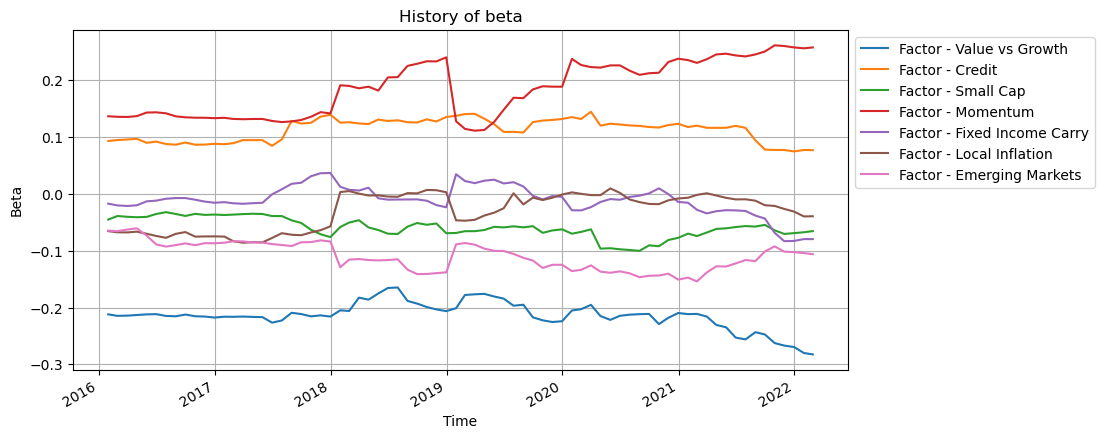

In [63]:
# plot the time history of beta for all factors used
rolling_beta_df.plot(figsize=(10, 5))
plt.grid()
plt.legend(bbox_to_anchor=(1, 1))
plt.ylabel('Beta')
plt.xlabel('Time')
plt.title('History of beta');

The chart above shows that the beta is not stationary overtime though they tend to fall within a range centring around the values obtained earlier when assuming constant betas over time. The non-stationarity of beta exhibited could be attributed to several factors, i.e., the change in investment methodology on the part of the Hedge fund, or the shift in market regime. Nonetheless, this could be source for concern for the following reasons:
- To dynamically manage a portfolio so that its returns mirrors that of the Hedge Fund could be costly, because trade cost would be incurred whenever the constituent factor is bought or sold, which could over compensate for the management fee saved.
- Actively trading constituent factors would also increase the volatility of the return of the Factor portfolio, which could render the risk-vs-reward comparison between the Hedge Fund and the Factor Portfolio no longer valid.
- The non-stationarity of the betas also highlights the fact the betas calculated with historical data is backward-looking, and are thus unlikely to be completely reliable when one wants to work out the look-ahead values at risk for the portfolio particularly when there is a shift in market regime.

The remedy for this could include training models which take into account market regime, i.e., different model deployed depending on the period that we are interested in. Alternatively, we could also consider train forward-looking models, (models that can predict the return of the portfolio a few days/weeks ahead), and accept the beta would be varying time and try to manage risk from the predicted returns. However, both methods suggested would require more data, not just over a longer period but also addition features such as some macro indicators, and more sophisticated modelling techniques.